# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

**The car dealer needs to understand which cars are valued by the buyers, so they know what cars keep in their inventory. From the data perspective, we will evaluate whether the price of the car is driven by the following factors: region, year, manufacturer, model, condition, fuel, cylinders, odometer, title_status, transmission, drive, size, type, paint color and state. Knowing the main factors, which determine the price of the cars, will drive the decision of which cars should be kept in order to maximize profit from selling the cars.**

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

**Several steps will be taken to get to know the dataset and identify any data quality issues with the dataset:**

1. Review of the columns in the dataset to ensure understanding of all the potential variables for the analysis.

2. Review of the rows in the dataset to identify duplicate records, outliers, records with missing values that can be excluded from the analysis sample

3. Review of the final analysis sample to identify any bias in the data (the data represent only certain categories of cars)


### Data Preparation

After our initial exploration and fine tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

In [207]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.inspection import permutation_importance
from sklearn.metrics import r2_score
from sklearn.feature_selection import SequentialFeatureSelector, RFE
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')


pd.set_option('display.max_rows', 500)	
pd.set_option('display.max_columns', 500)	
pd.set_option('display.width', 1000)	
pd.set_option('max_colwidth', None)	
	
	
from IPython.core.interactiveshell import InteractiveShell	
InteractiveShell.ast_node_interactivity = "all"	

In [208]:
#Read the dataset
df = pd.read_csv("data/vehicles.csv")
df.head()
df.shape

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
0,7222695916,prescott,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az
1,7218891961,fayetteville,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar
2,7221797935,florida keys,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl
3,7222270760,worcester / central MA,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma
4,7210384030,greensboro,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc


(426880, 18)

In [209]:
#Print percent of missing values in each column 
print(" \nPercent total NaN at each column in a DataFrame : \n\n",
      np.round(df.isnull().sum()/df.shape[0]*100,2),"%")

 
Percent total NaN at each column in a DataFrame : 

 id               0.00
region           0.00
price            0.00
year             0.28
manufacturer     4.13
model            1.24
condition       40.79
cylinders       41.62
fuel             0.71
odometer         1.03
title_status     1.93
transmission     0.60
VIN             37.73
drive           30.59
size            71.77
type            21.75
paint_color     30.50
state            0.00
dtype: float64 %


In [210]:
#Check to see if there are any duplicate records based on 'id'
print(f"Number of duplicate records based on id is {len(df)-len(df.drop_duplicates(subset = 'id'))}.")

Number of duplicate records based on id is 0.


In [211]:
#Check to see if there are any duplicate records based on 'VIN'
print(f"Number of duplicate records based on VIN is {len(df)-len(df.drop_duplicates(subset = 'VIN'))}.")

Number of duplicate records based on VIN is 308633.


**It is unexpected to see so many records with missing and duplicate VIN numbers. I will continue with this dataset without removing any records for missing/duplicate VIN. In real life, this needs to be discussed with the client.**


In [212]:
#Drop "id" and "VIN". They are match keys and won't be used in modeling.
df = df.drop(columns = ['id','VIN'])
df.shape

(426880, 16)

In [213]:
#create lists of numeric and categorical columns
EDA_df = df.copy()

EDA_cat_columns = EDA_df.select_dtypes(include=['object']).columns.tolist()
EDA_num_columns = EDA_df.select_dtypes(exclude=['object']).columns.tolist()

# Filter categorical columns with unique value count less than or equal to the specified threshold.
filtered_EDA_cat_columns = [col for col in EDA_cat_columns if EDA_df[col].nunique() <= 50]

In [214]:
EDA_cat_columns

['region',
 'manufacturer',
 'model',
 'condition',
 'cylinders',
 'fuel',
 'title_status',
 'transmission',
 'drive',
 'size',
 'type',
 'paint_color',
 'state']

In [215]:
EDA_num_columns

['price', 'year', 'odometer']

In [216]:
filtered_EDA_cat_columns

['manufacturer',
 'condition',
 'cylinders',
 'fuel',
 'title_status',
 'transmission',
 'drive',
 'size',
 'type',
 'paint_color']

In [217]:
# Define the plotting function
def plot_variable_distribution(dataframe, variable_name):
    plt.figure(figsize=(10, 6))  
    if dataframe[variable_name].dtype == 'object':
        # Categorical variables, draw a count plot
        sns.countplot(x=variable_name, data=dataframe)
        plt.xlabel(variable_name)
        plt.ylabel('Count')
        plt.title(f'Distribution of {variable_name}')
        plt.xticks(rotation=45)  
    else:
        # Numeric variables, plot histograms
        sns.histplot(dataframe[variable_name], kde=True)
        plt.xlabel(variable_name)
        plt.ylabel('Frequency')
        plt.title(f'Distribution of {variable_name}')
    plt.tight_layout()  
    plt.show()


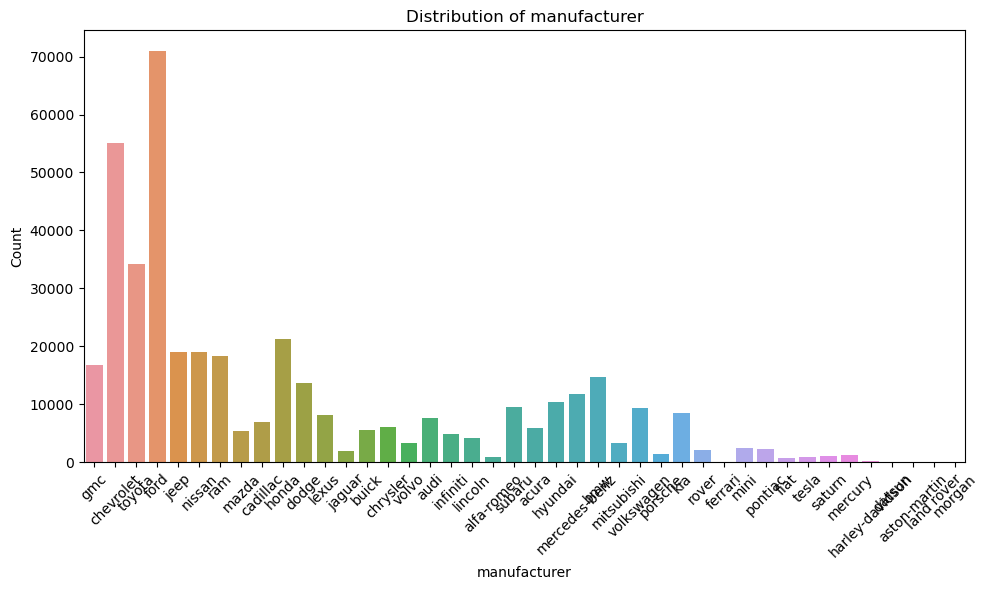

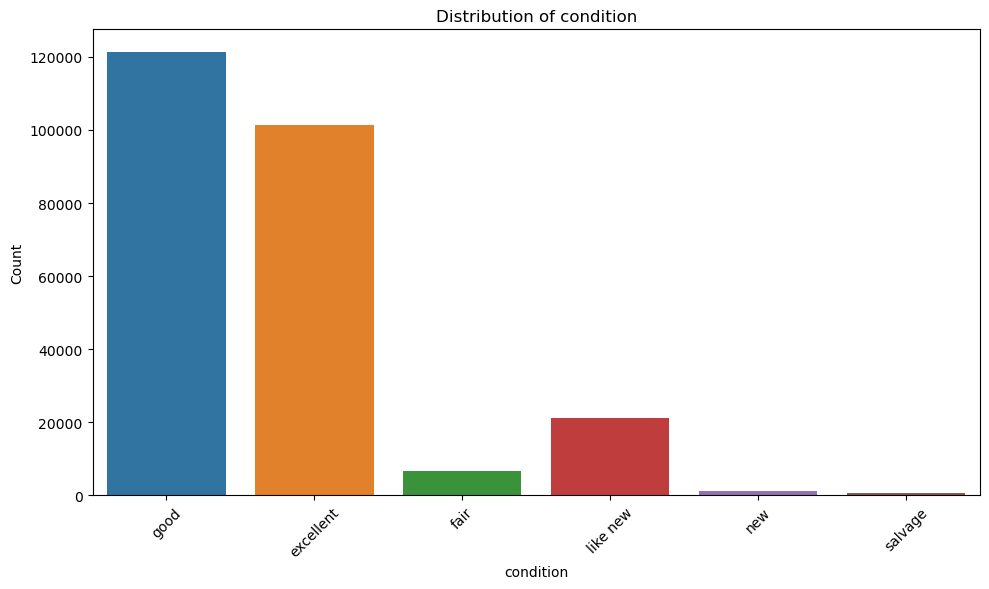

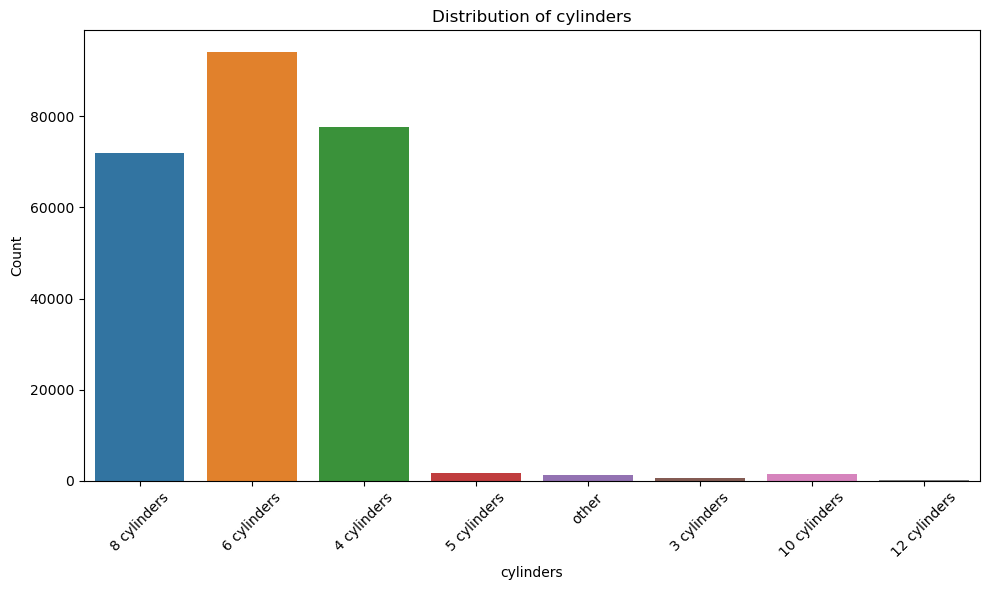

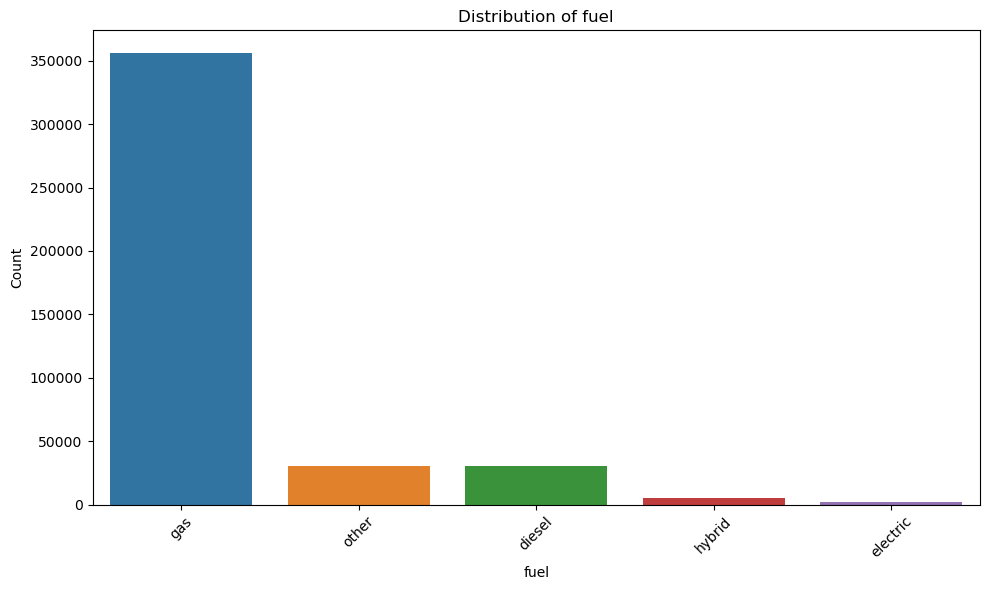

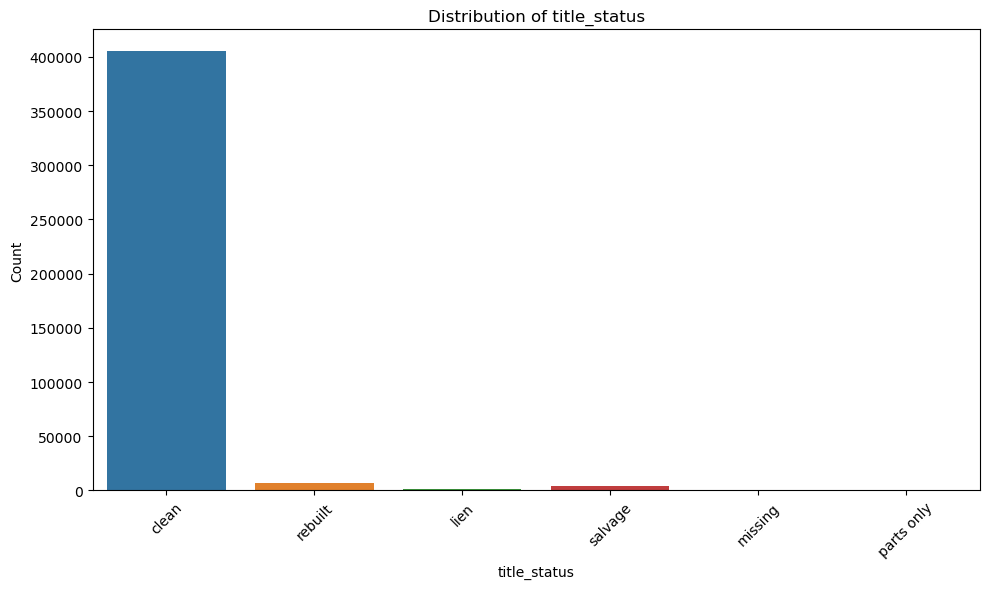

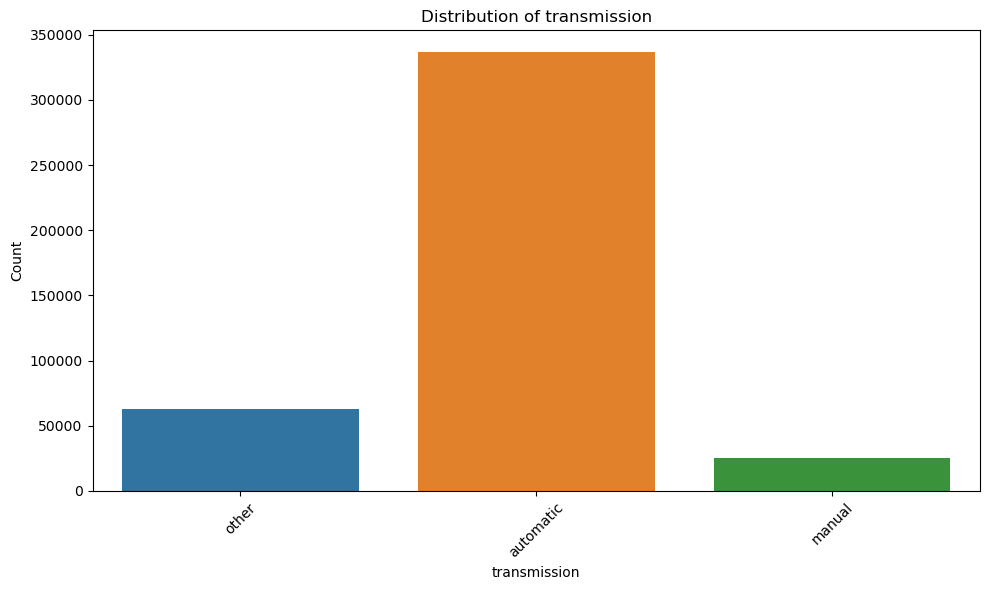

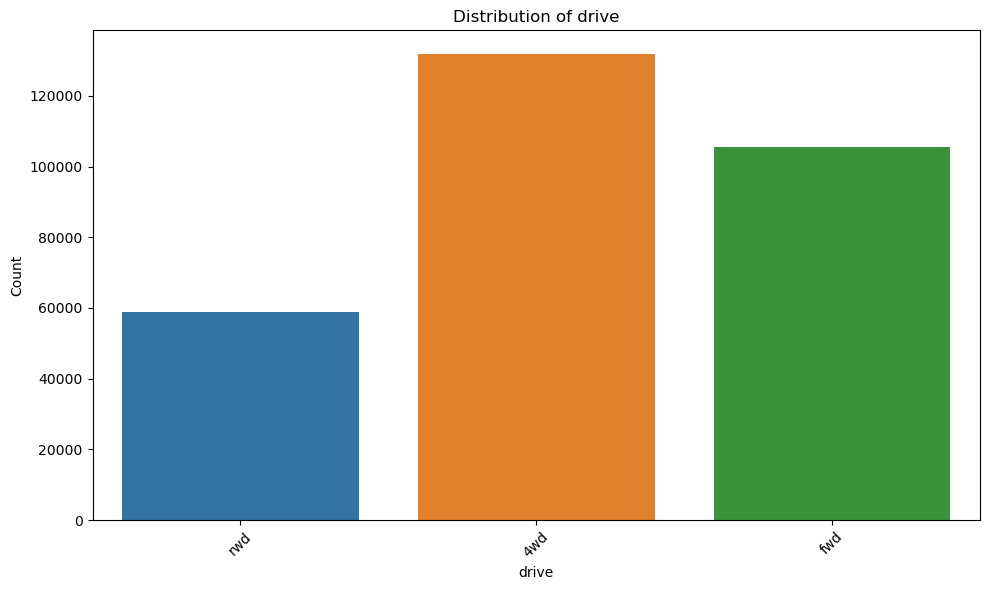

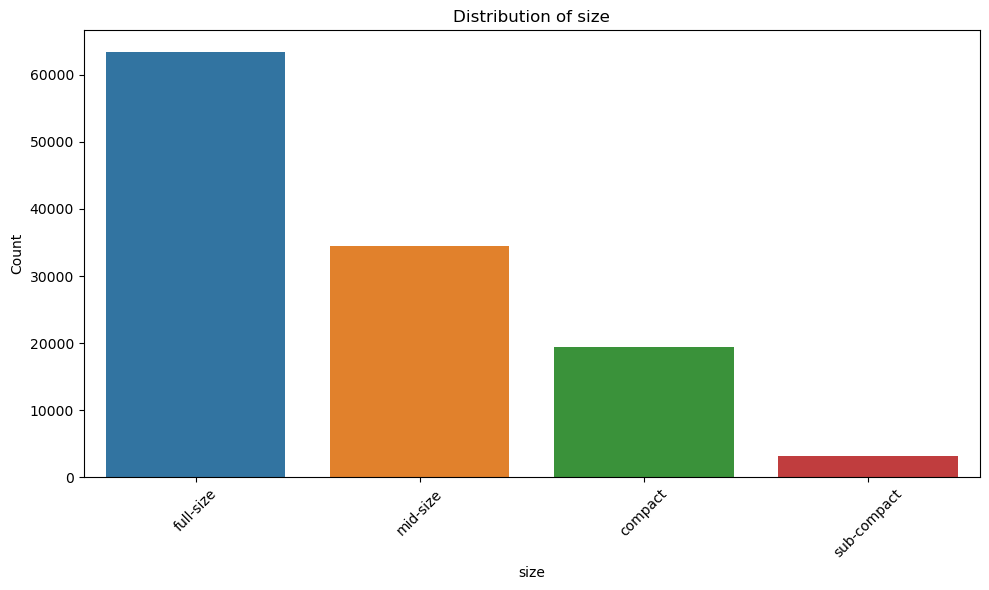

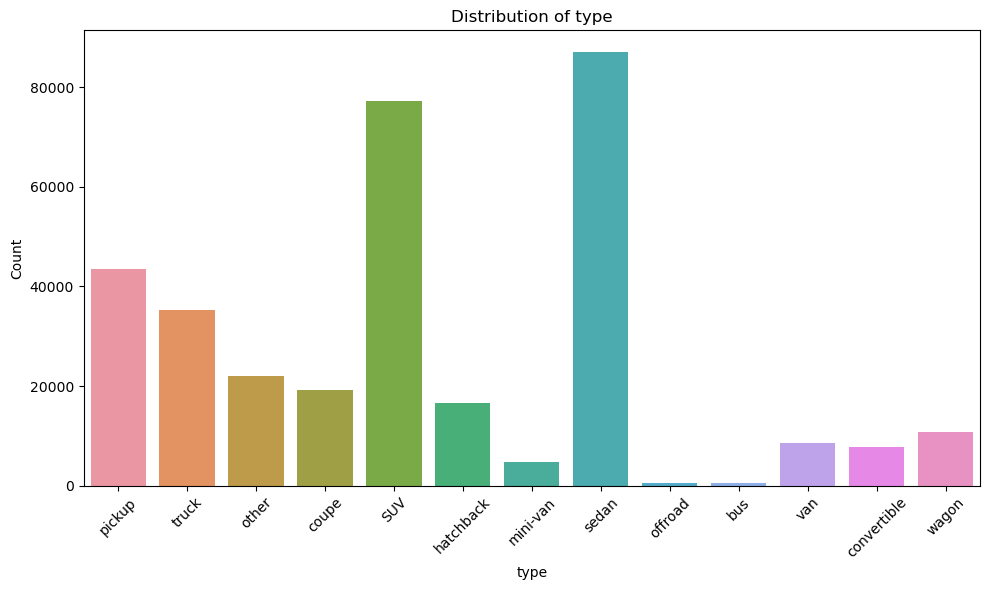

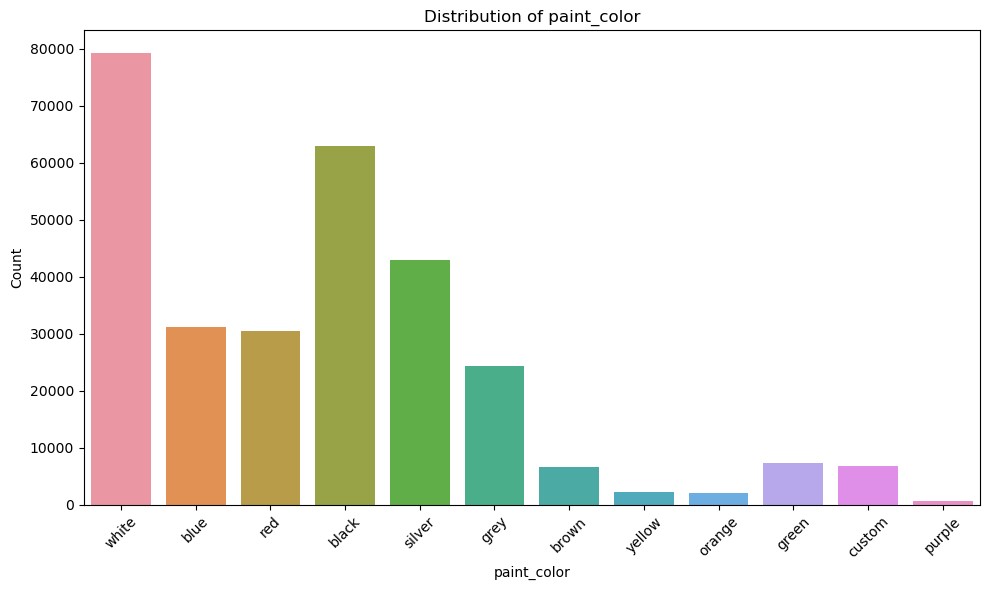

In [218]:
# Iterate through the list and plot each variable
for var in filtered_EDA_cat_columns:
    if var in EDA_df.columns:
        plot_variable_distribution(EDA_df, var)
    else:
        print(f"Column '{var}' does not exist in the DataFrame.")

In [219]:
#Remove new cars from the dataset since the dealer sells used cars.
df = df.query('condition != "new"')
df.shape

(425575, 16)

#### Actions taken for columns with missing values:

1) Year and odometer -> Drop the records with missing values since 'year' and 'odometer' should be strong predictors of the price and less than 1.5% of the records are missing.

2) Manufacturer, model, condition, cylinders, fuel, title_status, transmission, drive, size, type and paint_color -> Replace missing values with 'missing' category, as these are categorical variables and they will be hot encoded for the regression model. 'Missing' will have its own category.

In [220]:
#Drop records with 'year' and 'odometer' missing
df2 = df.dropna(subset = ['year','odometer'])

#Replace the other categorical variables with missing values with 'missing'
for i in EDA_cat_columns:
    df2[i] = df2[i].fillna("missing")
    
df2.shape

(420041, 16)

In [221]:
#Confirm there are no columns with missing values
df2.isna().sum()

region          0
price           0
year            0
manufacturer    0
model           0
condition       0
cylinders       0
fuel            0
odometer        0
title_status    0
transmission    0
drive           0
size            0
type            0
paint_color     0
state           0
dtype: int64

In [222]:
df2

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state
27,auburn,33590,2014.0,gmc,sierra 1500 crew cab slt,good,8 cylinders,gas,57923.0,clean,other,missing,missing,pickup,white,al
28,auburn,22590,2010.0,chevrolet,silverado 1500,good,8 cylinders,gas,71229.0,clean,other,missing,missing,pickup,blue,al
29,auburn,39590,2020.0,chevrolet,silverado 1500 crew,good,8 cylinders,gas,19160.0,clean,other,missing,missing,pickup,red,al
30,auburn,30990,2017.0,toyota,tundra double cab sr,good,8 cylinders,gas,41124.0,clean,other,missing,missing,pickup,red,al
31,auburn,15000,2013.0,ford,f-150 xlt,excellent,6 cylinders,gas,128000.0,clean,automatic,rwd,full-size,truck,black,al
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426875,wyoming,23590,2019.0,nissan,maxima s sedan 4d,good,6 cylinders,gas,32226.0,clean,other,fwd,missing,sedan,missing,wy
426876,wyoming,30590,2020.0,volvo,s60 t5 momentum sedan 4d,good,missing,gas,12029.0,clean,other,fwd,missing,sedan,red,wy
426877,wyoming,34990,2020.0,cadillac,xt4 sport suv 4d,good,missing,diesel,4174.0,clean,other,missing,missing,hatchback,white,wy
426878,wyoming,28990,2018.0,lexus,es 350 sedan 4d,good,6 cylinders,gas,30112.0,clean,other,fwd,missing,sedan,silver,wy


In [223]:
#Analyze distribution for numeric columns
df2.describe()

,price,year,odometer
count,4.200410e+05,420041.000000,4.200410e+05
mean,7.614577e+04,2011.219024,9.838915e+04
std,1.228105e+07,9.441120,2.143805e+05
min,0.000000e+00,1900.000000,0.000000e+00
25%,5.977000e+03,2008.000000,3.813000e+04
50%,1.398800e+04,2013.000000,8.600000e+04
75%,2.644600e+04,2017.000000,1.339600e+05
max,3.736929e+09,2022.000000,1.000000e+07


In [224]:
#Analyze the distribution of the odometer to detect any data entry issues
odometerBinning = [0,1,10,100,1000,999_999,float("inf")]
df2["odometer_bin"] = pd.cut(x=df2["odometer"],right=False,bins = odometerBinning)
df2['odometer_bin'].value_counts().sort_index()
df2.shape

odometer_bin
[0.0, 1.0)              1935
[1.0, 10.0)             2838
[10.0, 100.0)           1348
[100.0, 1000.0)         3432
[1000.0, 999999.0)    409619
[999999.0, inf)          869
Name: count, dtype: int64

(420041, 17)

In [225]:
#Keep records with odometer > 0 and <1,000,000. Values beyond are likely data issue

df2 = df2[(df2['odometer']>0) & (df2['odometer']<1_000_000)]
df2.shape

(417471, 17)

In [226]:
#Remove recors with price=0
df2 = df2.query('price > 0')
df2.shape

(387834, 17)

In [227]:
# Check distribution after cleaning numeric columns
df2.describe()

,price,year,odometer
count,3.878340e+05,387834.000000,387834.000000
mean,7.922476e+04,2011.044181,94242.691221
std,1.267894e+07,9.500250,71141.262704
min,1.000000e+00,1900.000000,1.000000
25%,7.099000e+03,2008.000000,38872.000000
50%,1.500000e+04,2013.000000,87591.500000
75%,2.759000e+04,2017.000000,135550.000000
max,3.736929e+09,2022.000000,999999.000000


In [228]:
#Get the distribution of the price to detect any data entry issue
priceBinning = [0,10_000,20000,30000,40000,50000,60000,70000,80000,90000,100000,4000000000]
df2["price_bin"] = pd.cut(x=df2["price"],right=False,bins = priceBinning)
df2['price_bin'].value_counts().sort_index()

price_bin
[0, 10000)              139852
[10000, 20000)          101477
[20000, 30000)           68897
[30000, 40000)           49486
[40000, 50000)           15718
[50000, 60000)            6457
[60000, 70000)            2991
[70000, 80000)            1457
[80000, 90000)             620
[90000, 100000)            231
[100000, 4000000000)       648
Name: count, dtype: int64

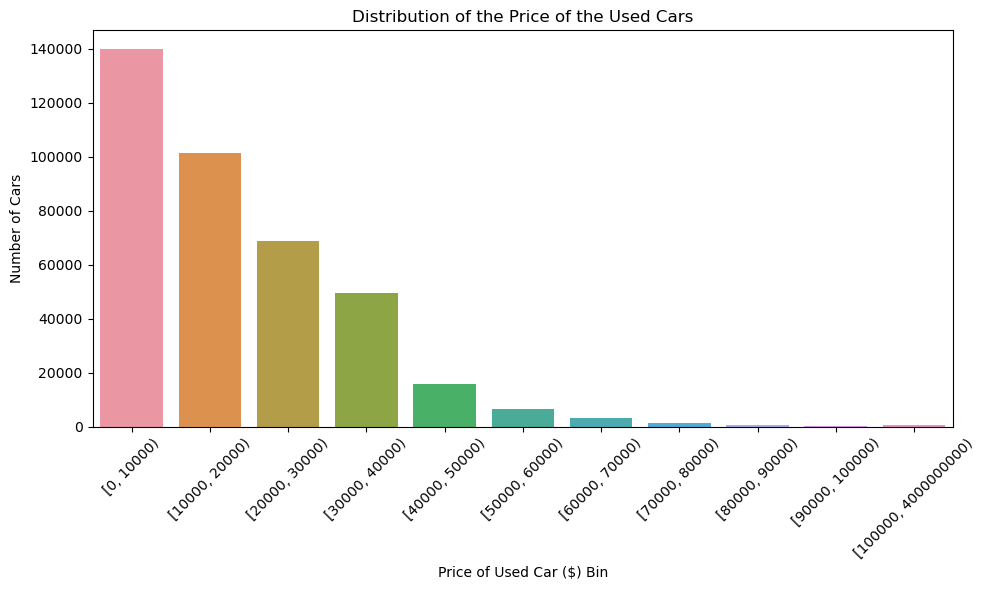

In [229]:
# Plot the distribution of the price
df2['price_bin_str'] = pd.Categorical(df2['price_bin'].astype(str), 
                                      categories=[str(bin) for bin in sorted(df2['price_bin'].unique())], 
                                      ordered=True)

plt.figure(figsize=(10, 6))
sns.countplot(x='price_bin_str', data=df2, order=df2['price_bin_str'].cat.categories)
plt.xlabel("Price of Used Car ($) Bin")
plt.ylabel("Number of Cars")
plt.title('Distribution of the Price of the Used Cars')
plt.xticks(rotation=45) 
plt.tight_layout()
plt.show();

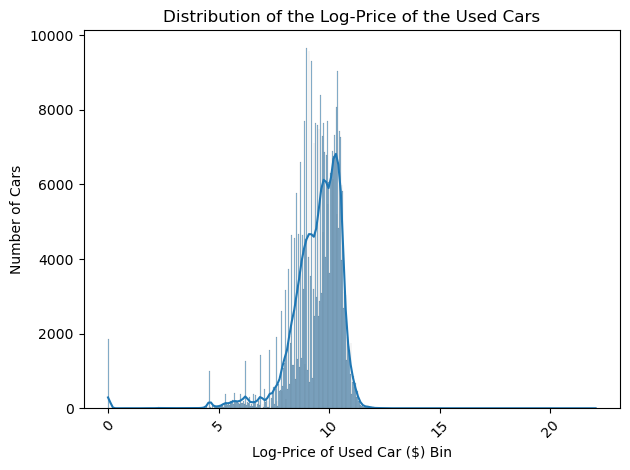

In [230]:
#Apply log transformation on the price to get a normal distribution
df2['price_log'] = np.log(df2['price'])
sns.histplot(df2['price_log'], kde=True)
plt.xlabel("Log-Price of Used Car ($) Bin")
plt.ylabel("Number of Cars")
plt.title('Distribution of the Log-Price of the Used Cars')
plt.xticks(rotation=45)  # Rotate labels for readability
plt.tight_layout()
plt.show();

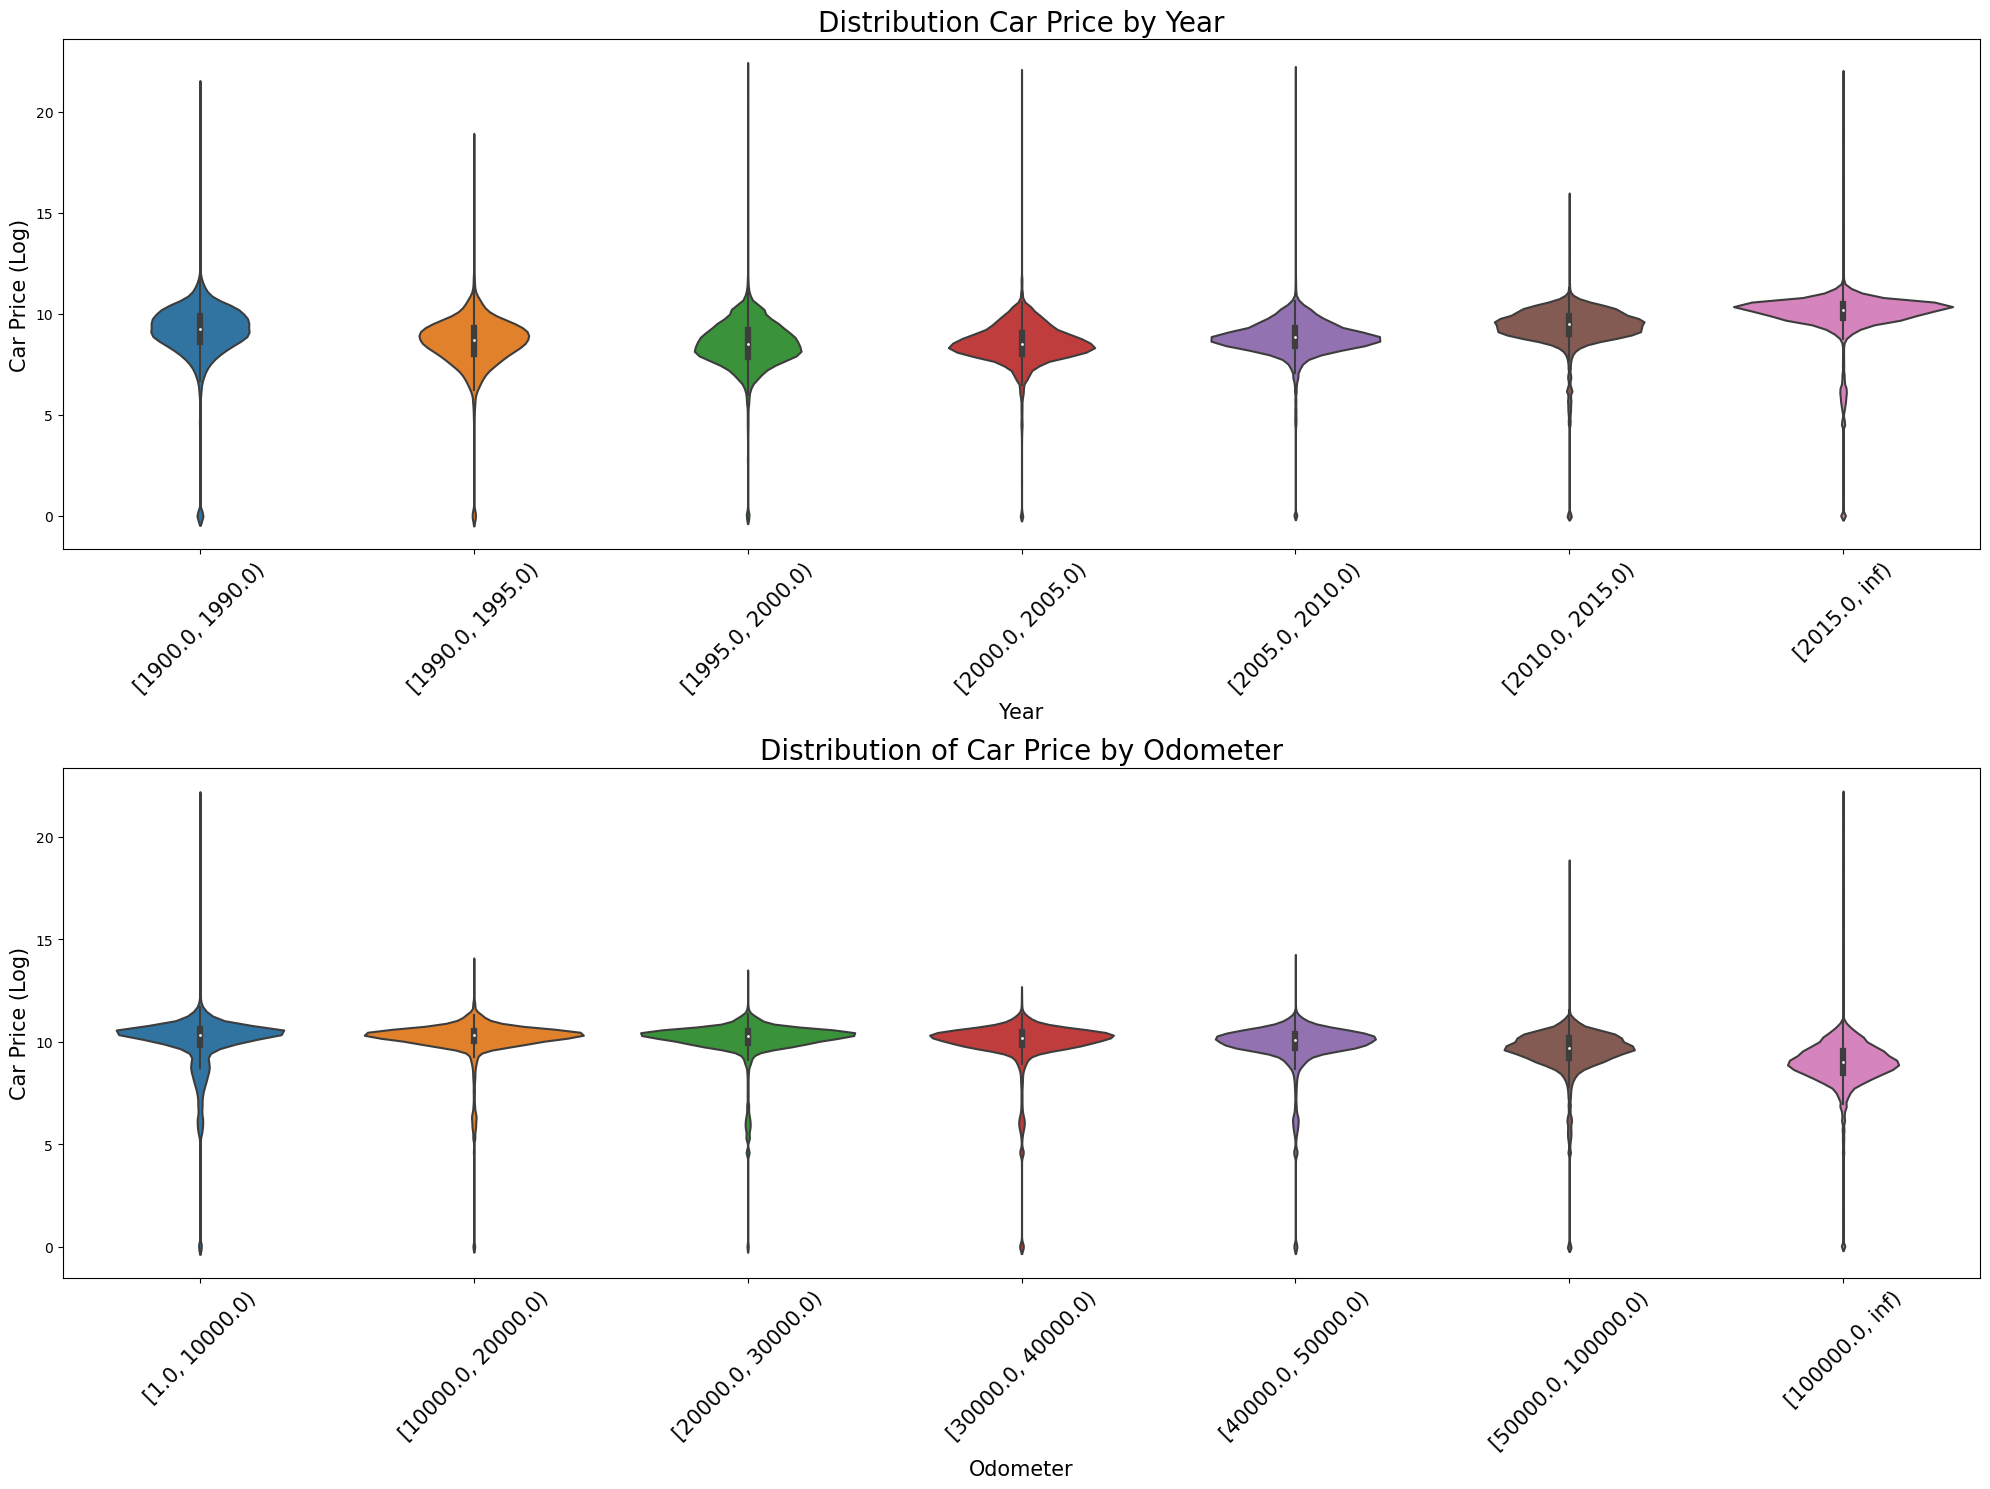

In [244]:
#Create the vioin plots for 'year' and 'odometer'

fig, ax = plt.subplots(2, 1, figsize = (20, 15))

#Year
yearBinning = [1900,1990,1995,2000,2005,2010,2015,float("inf")]
df2["year_bin"] = pd.cut(x=df2["year"],right=False,bins = yearBinning)

sns.violinplot(ax = ax[0], x = 'year_bin', y = 'price_log', data = df2);
ax[0].set_title("Distribution Car Price by Year", fontsize = 20)
ax[0].set_xlabel("Year", fontsize = 15)
ax[0].set_ylabel("Car Price (Log)", fontsize = 15)
ax[0].tick_params(axis = 'x',labelrotation=45,labelsize = '15')

#Odometer
odometerBinning = [1,10_000,20_000,30_000,40_000,50_000,100_000,float("inf")]
df2["odometer_bin"] = pd.cut(x=df2["odometer"],right=False,bins = odometerBinning)

sns.violinplot(ax = ax[1], x = 'odometer_bin', y = 'price_log', data = df2);
ax[1].set_title("Distribution of Car Price by Odometer", fontsize = 20)
ax[1].set_xlabel("Odometer", fontsize = 15)
ax[1].set_ylabel("Car Price (Log)", fontsize = 15)
ax[1].tick_params(axis = 'x',labelrotation=45,labelsize = '15')

fig.tight_layout();
plt.savefig('./images/CarPriceNumChars.jpg');


In [232]:
df2.head()

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state,odometer_bin,price_bin,price_bin_str,price_log,year_bin
27,auburn,33590,2014.0,gmc,sierra 1500 crew cab slt,good,8 cylinders,gas,57923.0,clean,other,missing,missing,pickup,white,al,"[50000.0, 100000.0)","[30000, 40000)","[30000, 40000)",10.421984,"[2010.0, 2015.0)"
28,auburn,22590,2010.0,chevrolet,silverado 1500,good,8 cylinders,gas,71229.0,clean,other,missing,missing,pickup,blue,al,"[50000.0, 100000.0)","[20000, 30000)","[20000, 30000)",10.025263,"[2010.0, 2015.0)"
29,auburn,39590,2020.0,chevrolet,silverado 1500 crew,good,8 cylinders,gas,19160.0,clean,other,missing,missing,pickup,red,al,"[10000.0, 20000.0)","[30000, 40000)","[30000, 40000)",10.586332,"[2015.0, inf)"
30,auburn,30990,2017.0,toyota,tundra double cab sr,good,8 cylinders,gas,41124.0,clean,other,missing,missing,pickup,red,al,"[40000.0, 50000.0)","[30000, 40000)","[30000, 40000)",10.341420,"[2015.0, inf)"
31,auburn,15000,2013.0,ford,f-150 xlt,excellent,6 cylinders,gas,128000.0,clean,automatic,rwd,full-size,truck,black,al,"[100000.0, inf)","[10000, 20000)","[10000, 20000)",9.615805,"[2010.0, 2015.0)"


In [233]:
#Drop 'price' from the dataset
df2 = df2.drop(columns = ['price','price_bin','price_bin_str'])

In [234]:
#From analysis above it looks like region and model have more than 50 values. 
#I will remove 'region' since there is a 'state' indicator as a proxy.
#I will remove 'model' since the variable is not clean, and manufacturer column can be used instead.

df2 = df2.drop(columns = ['region','model'])
df2.shape

(387834, 16)

In [235]:
#Drop odometer_bin and year_bin
df3= df2.drop(columns = ['odometer_bin','year_bin'])

In [236]:
df3.head()

,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state,price_log
27,2014.0,gmc,good,8 cylinders,gas,57923.0,clean,other,missing,missing,pickup,white,al,10.421984
28,2010.0,chevrolet,good,8 cylinders,gas,71229.0,clean,other,missing,missing,pickup,blue,al,10.025263
29,2020.0,chevrolet,good,8 cylinders,gas,19160.0,clean,other,missing,missing,pickup,red,al,10.586332
30,2017.0,toyota,good,8 cylinders,gas,41124.0,clean,other,missing,missing,pickup,red,al,10.341420
31,2013.0,ford,excellent,6 cylinders,gas,128000.0,clean,automatic,rwd,full-size,truck,black,al,9.615805


### Review the relationship of price with the numeric variables

In [237]:
#Review the correlation between price and the numeric predictor variables, year and odometer
correlation_matrix = df3[['year','odometer','price_log']].corr()
print(correlation_matrix)

               year  odometer  price_log
year       1.000000 -0.306148   0.276953
odometer  -0.306148  1.000000  -0.322118
price_log  0.276953 -0.322118   1.000000


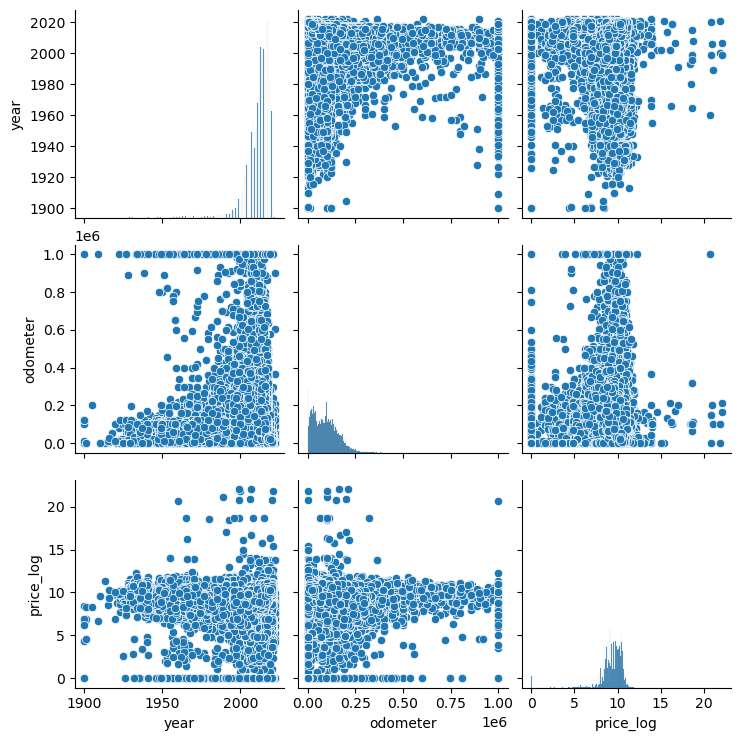

In [238]:
sns.pairplot(df3[['year','odometer','price_log']]);

#### Observations on numeric variables abd their reationship with target (log-price)
1) Log-Price increases with year (newer cars get higher resale price)
2) Log-Price generally decreases with mileage (odometer values)

In [239]:
#Create a distribution of median price for each categorical variable

def plot_variable_distribution(dataframe, variable_name):
    plt.figure(figsize=(10, 6))  
    if dataframe[variable_name].dtype == 'object':
        # Categorical variables, draw a bar plot 
        mean_values = dataframe.groupby(variable_name)['price_log'].mean().reset_index().sort_values('price_log', ascending=False)
        plt.bar(mean_values[variable_name], mean_values['price_log'])
        plt.xlabel(variable_name)
        plt.ylabel('Mean Log-Price')
        plt.title(f'Mean of Log-Price by {variable_name}')
        plt.xticks(rotation=45)  
    plt.tight_layout()  
    plt.show()

Column 'region' does not exist in the DataFrame.


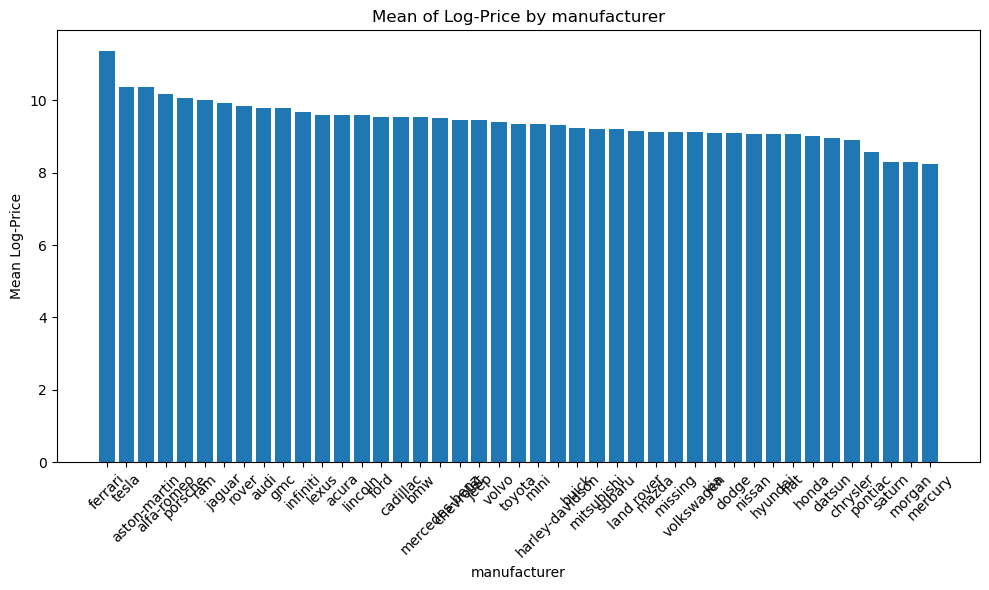

Column 'model' does not exist in the DataFrame.


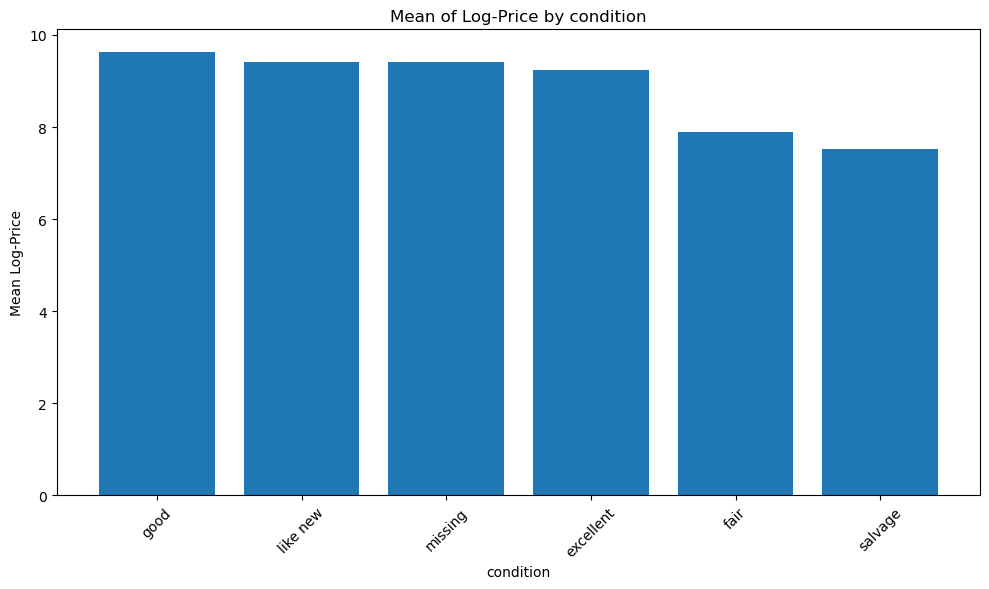

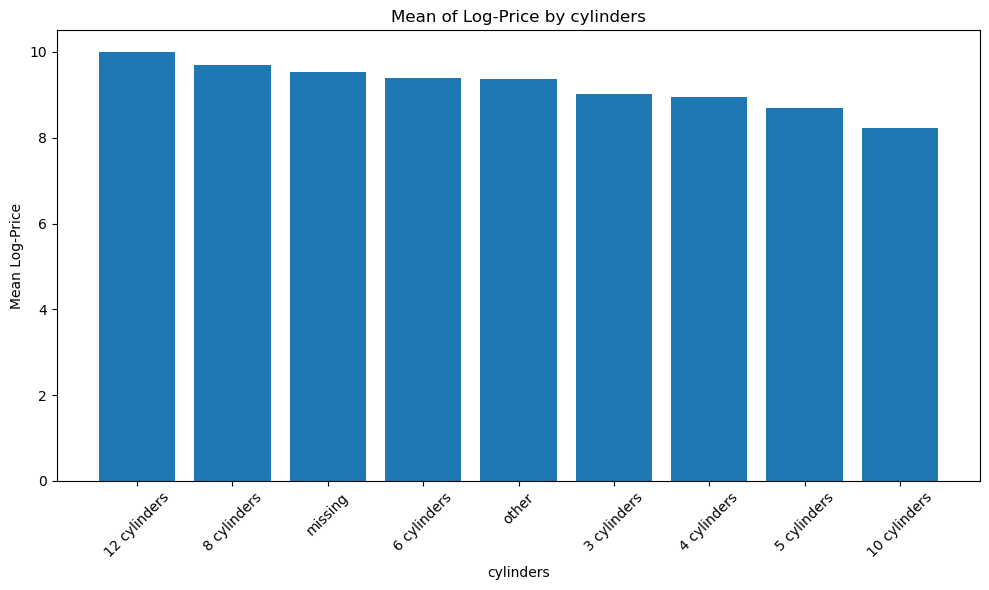

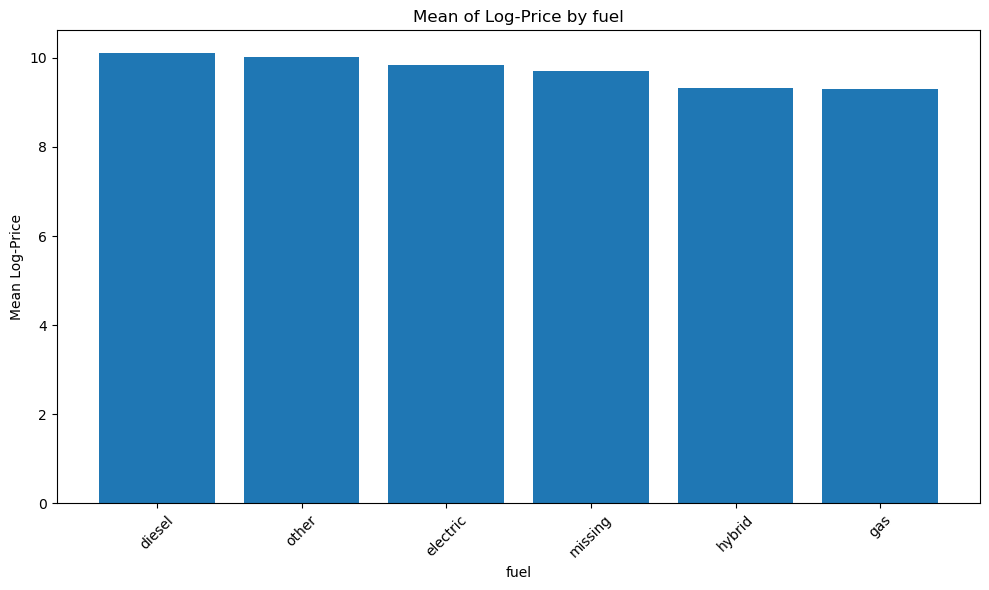

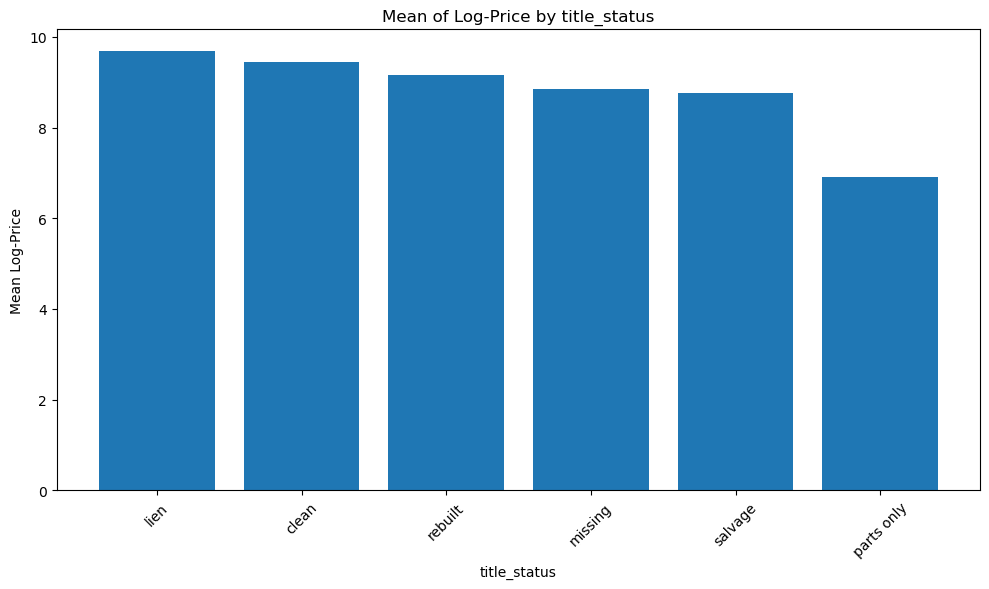

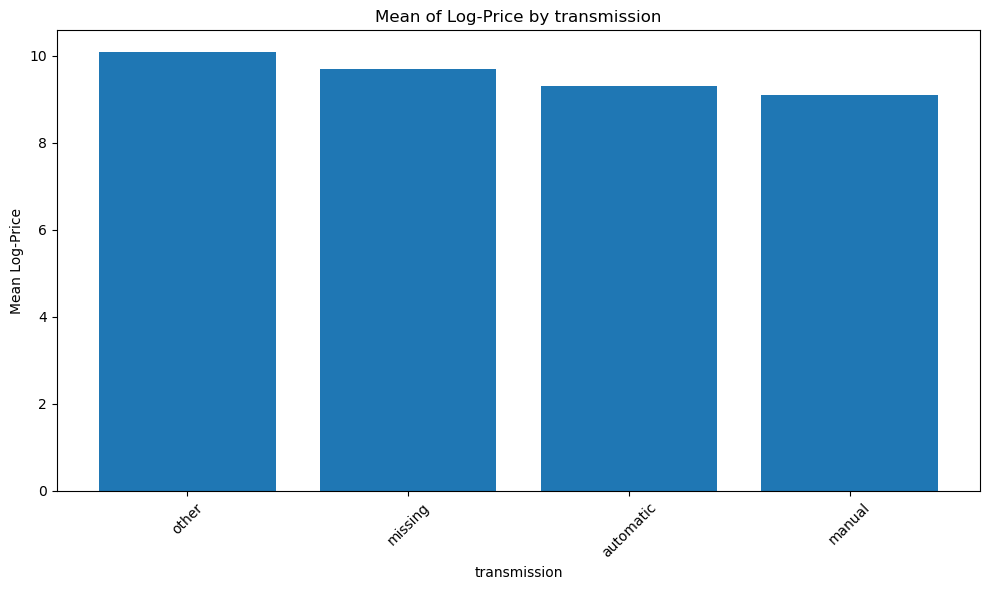

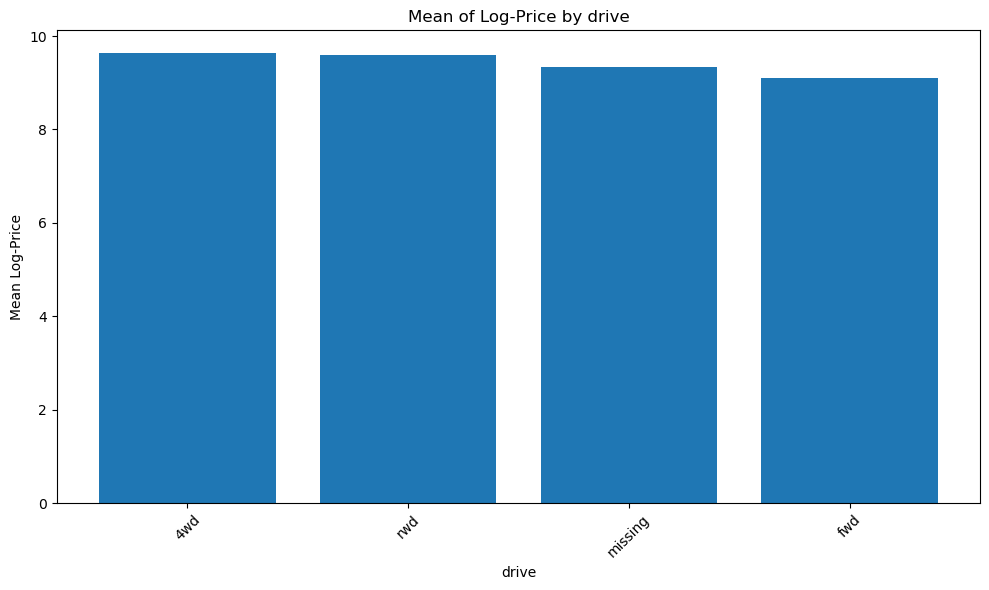

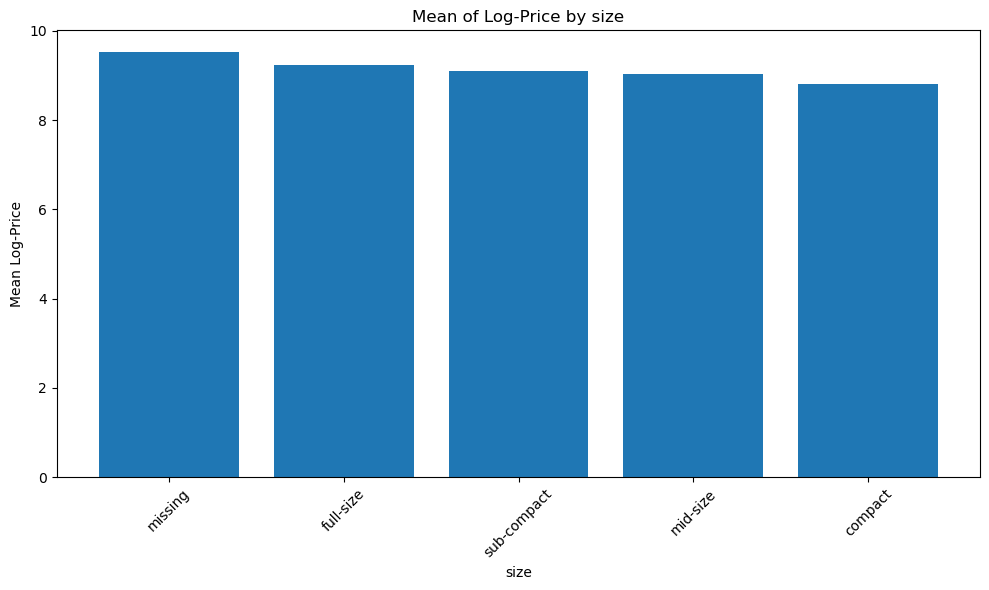

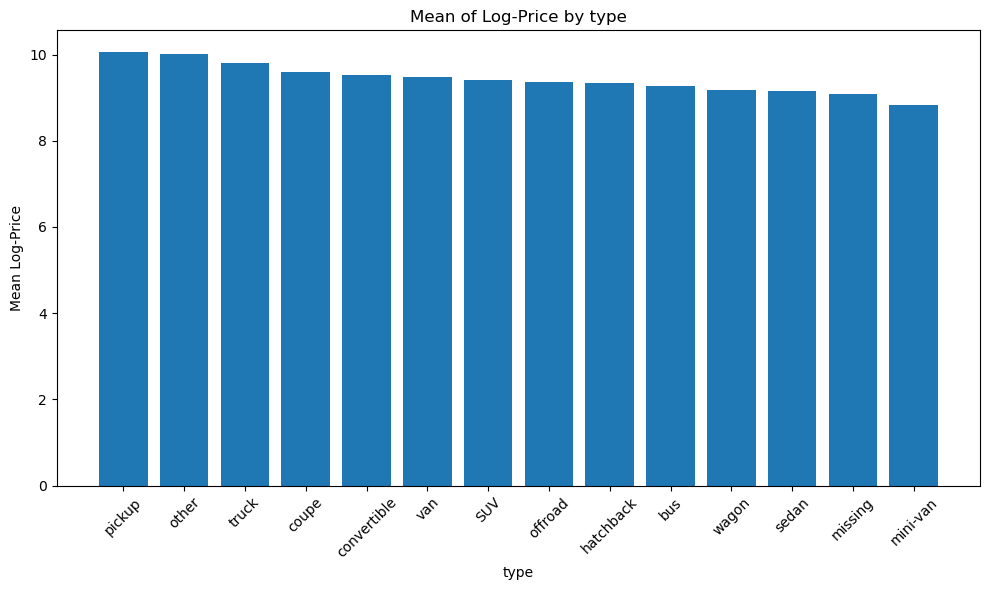

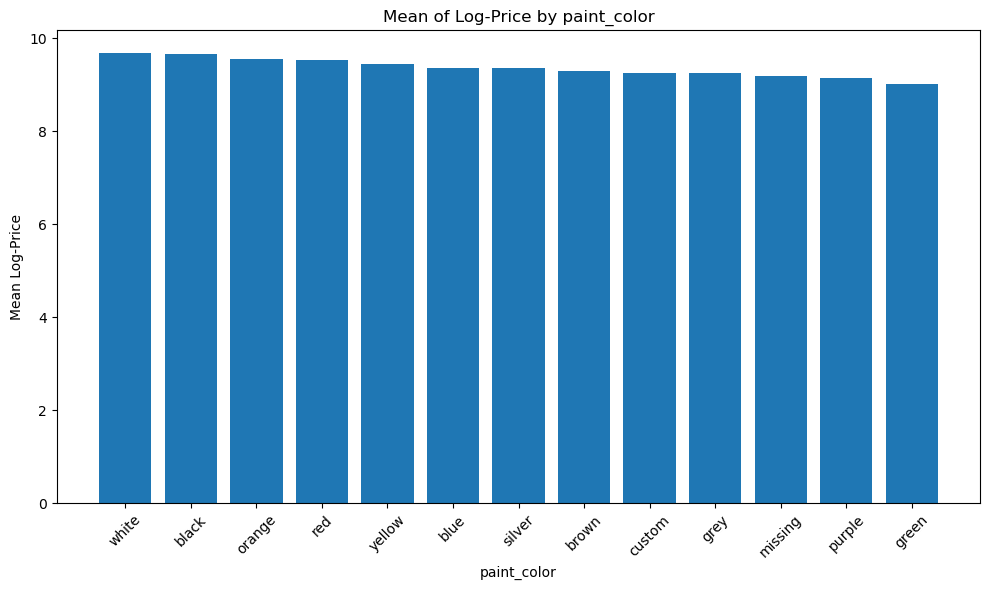

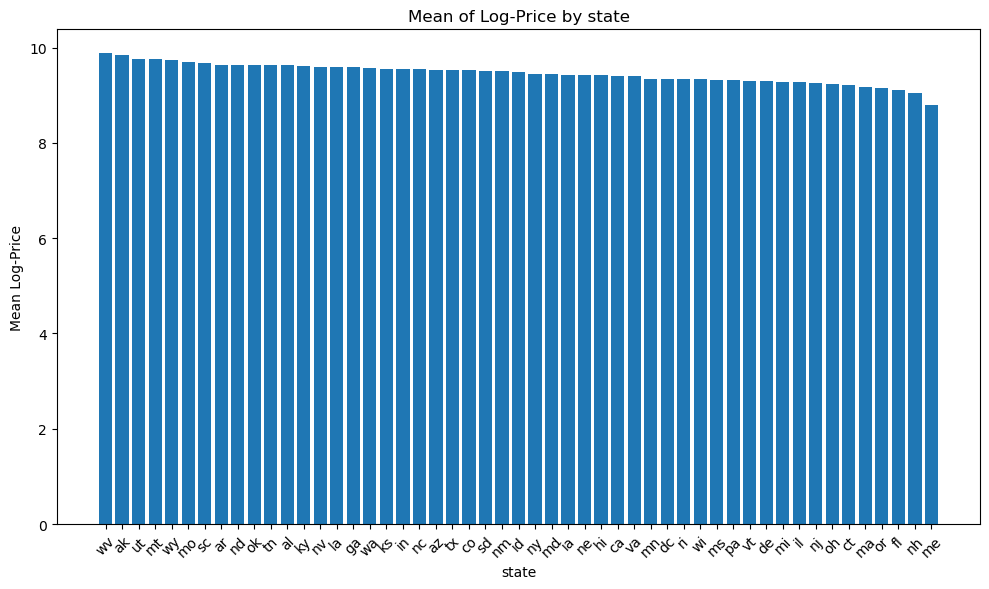

In [240]:
# Iterate through the list and plot each variable
for var in EDA_cat_columns:
    if var in df3.columns:
        plot_variable_distribution(df3, var)
    else:
        print(f"Column '{var}' does not exist in the DataFrame.")

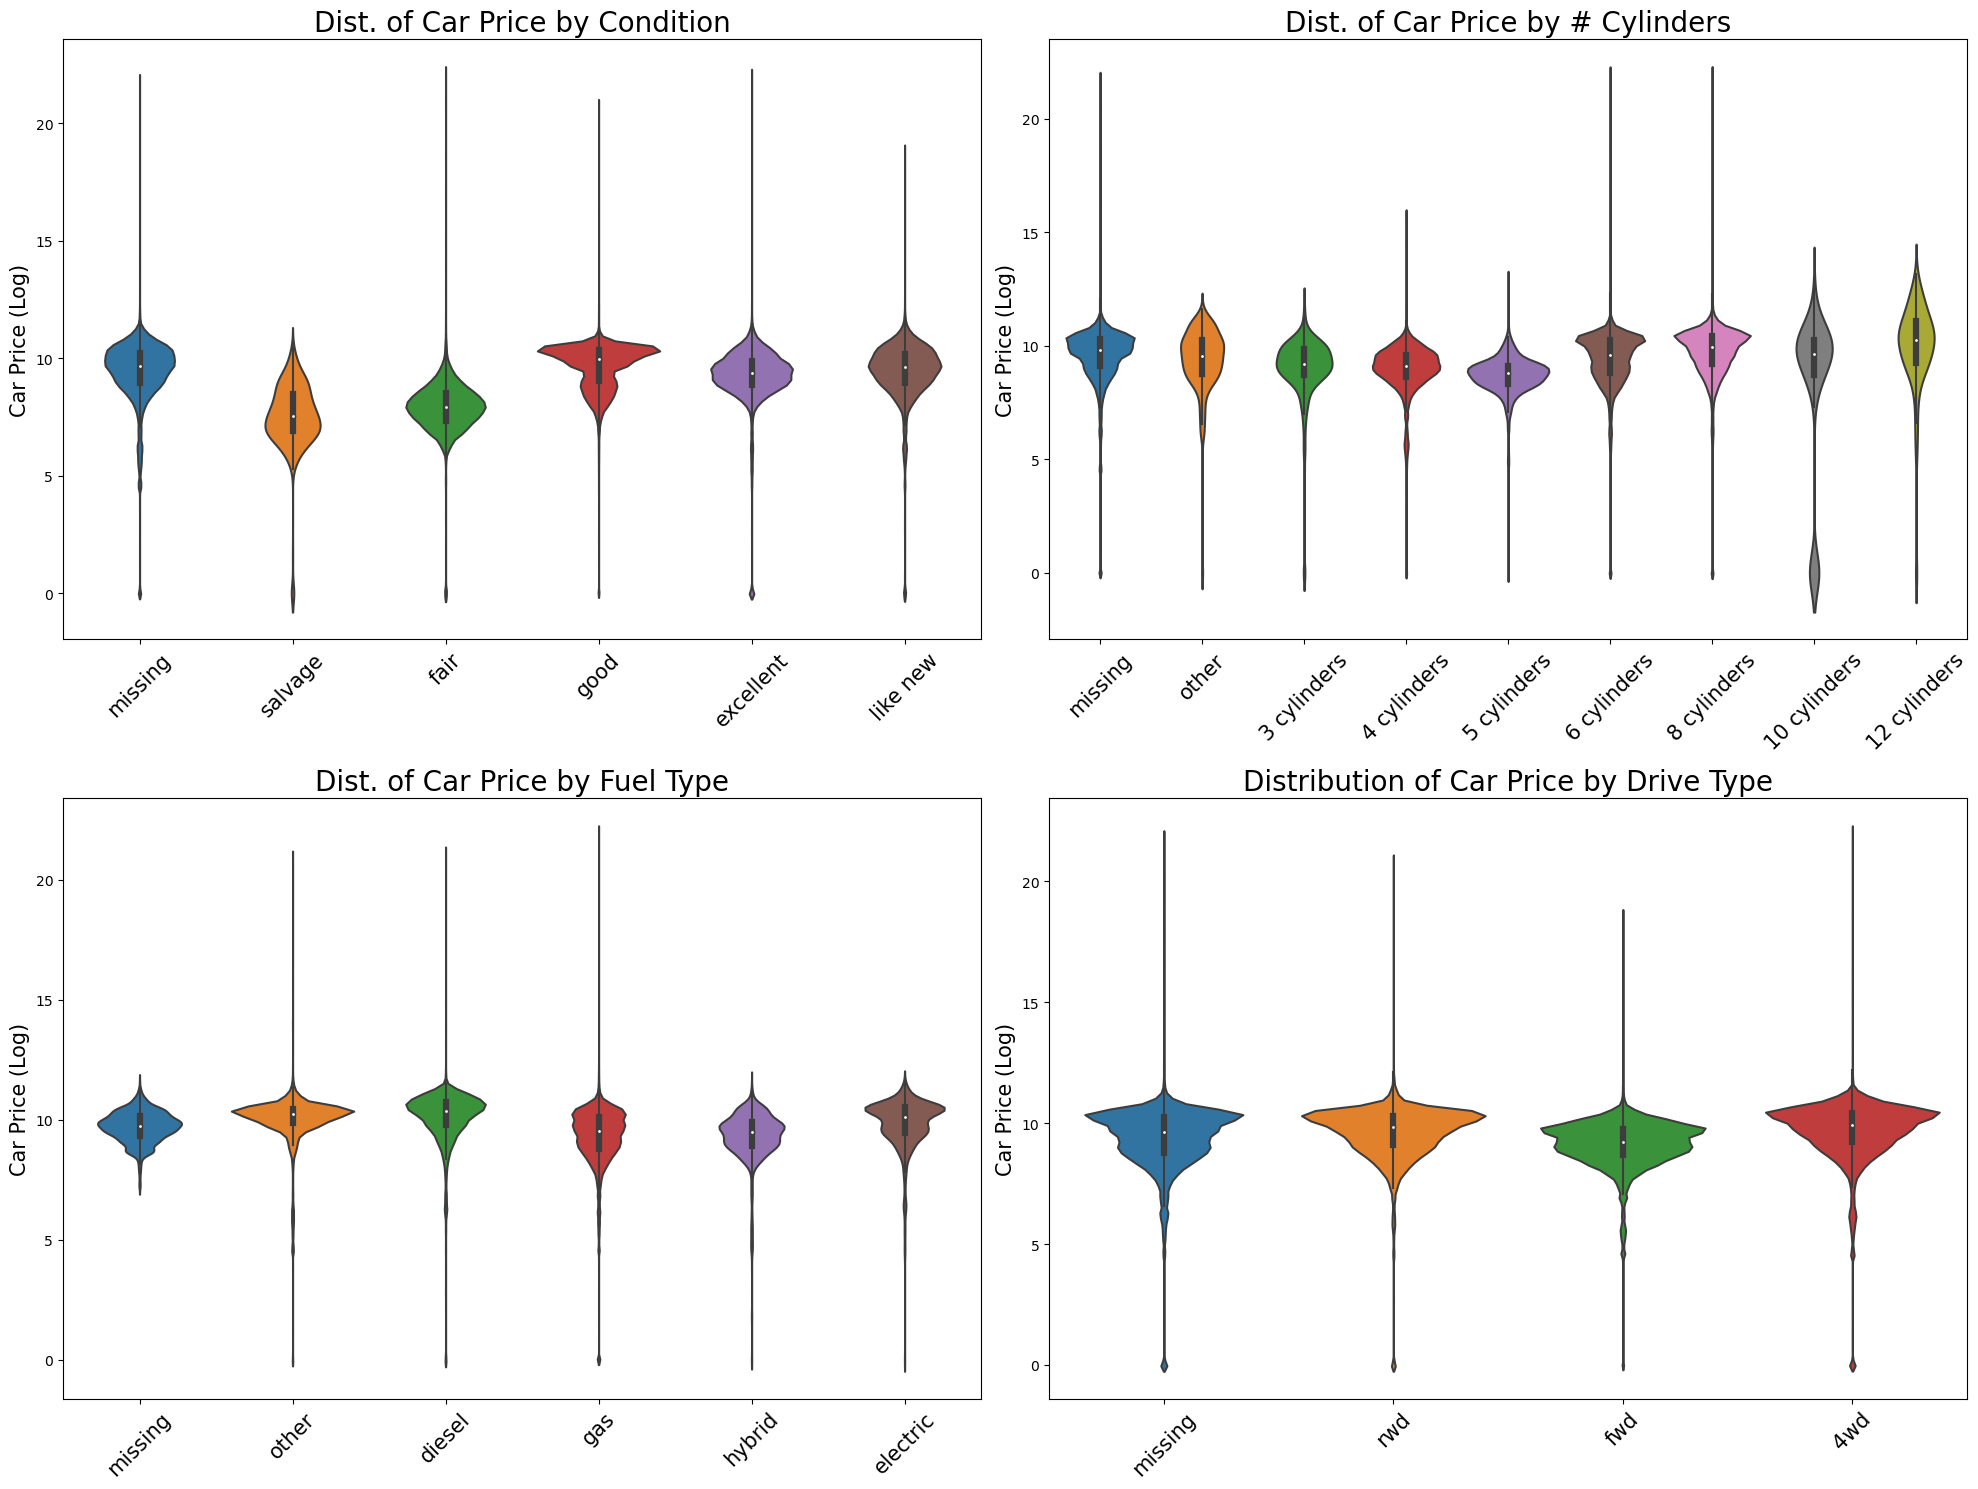

In [245]:
#Create the distribution of price for main categorical variables
fig, ax = plt.subplots(2, 2, figsize = (20, 15))

#Condition
sns.violinplot(ax = ax[0,0], x = 'condition', y = 'price_log', data = df3, 
               order = ['missing','salvage','fair','good','excellent','like new']);
ax[0,0].set_title("Dist. of Car Price by Condition", fontsize = 20)
ax[0,0].set_ylabel("Car Price (Log)", fontsize = 15)
ax[0,0].set_xlabel("", fontsize = 15)
ax[0,0].tick_params(axis = 'x',labelrotation=45,labelsize = '15')

#Cylinders
sns.violinplot(ax = ax[0,1], x = 'cylinders', y = 'price_log', data = df3,
    order = ['missing','other','3 cylinders', '4 cylinders','5 cylinders','6 cylinders','8 cylinders','10 cylinders', '12 cylinders']);
ax[0,1].set_title("Dist. of Car Price by # Cylinders", fontsize = 20)
ax[0,1].set_ylabel("Car Price (Log)", fontsize = 15)
ax[0,1].set_xlabel("", fontsize = 15)
ax[0,1].tick_params(axis = 'x',labelrotation=45,labelsize = '15')

#Fuel
sns.violinplot(ax = ax[1,0], x = 'fuel', y = 'price_log', data = df3,
    order = ['missing','other','diesel','gas','hybrid','electric']);
ax[1,0].set_title("Dist. of Car Price by Fuel Type", fontsize = 20)
ax[1,0].set_ylabel("Car Price (Log)", fontsize = 15)
ax[1,0].set_xlabel("", fontsize = 15)
ax[1,0].tick_params(axis = 'x',labelrotation=45,labelsize = '15')

#Drive
sns.violinplot(ax = ax[1,1], x = 'drive', y = 'price_log', data = df3,
    order = ['missing','rwd','fwd','4wd']);
ax[1,1].set_title("Distribution of Car Price by Drive Type", fontsize = 20)
ax[1,1].set_ylabel("Car Price (Log)", fontsize = 15)
ax[1,1].set_xlabel("", fontsize = 15)
ax[1,1].tick_params(axis = 'x',labelrotation=45,labelsize = '15')

fig.tight_layout()

plt.savefig('./images/CarPriceCatChars.jpg');

### Observations on categorical variables that will be used for modeling

1) There is good separation for log-car price with condition, number of cylinders, title status and drive type.
2) Other variables seem to be less correlated with the resale value even though we still observe some signal.
   
    -  White cars seem to have a higher resale.
    -  Ferraris are luxury cars and are the most expensive. The cheaper cars are less known manufacturers (saturn, morgan and mercury).
    -  Full size cars are more expensive, while compact are the least expensive.
    -  Pick up and trucks tend to be more expensive.
    -  It seems West Virginia generally has the highest resale price. Maine has the lowest.
    -  4wd cars are more expensive.

### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

### Prepare independent variables for model development

In [242]:
#One-hot encode all the categorical variables

listOHE = ['manufacturer','condition','cylinders','fuel','title_status','transmission','drive','size','type',
                    'paint_color','state']

df4 = pd.get_dummies(df3[listOHE],drop_first = True)

# Ensure that the values are 0/1
df4 = df4.astype(int)

df5 = df3.drop(columns = listOHE)
df6 = df4.join(df5)
df6.head()
df6.shape

,manufacturer_alfa-romeo,manufacturer_aston-martin,manufacturer_audi,manufacturer_bmw,manufacturer_buick,manufacturer_cadillac,manufacturer_chevrolet,manufacturer_chrysler,manufacturer_datsun,manufacturer_dodge,manufacturer_ferrari,manufacturer_fiat,manufacturer_ford,manufacturer_gmc,manufacturer_harley-davidson,manufacturer_honda,manufacturer_hyundai,manufacturer_infiniti,manufacturer_jaguar,manufacturer_jeep,manufacturer_kia,manufacturer_land rover,manufacturer_lexus,manufacturer_lincoln,manufacturer_mazda,manufacturer_mercedes-benz,manufacturer_mercury,manufacturer_mini,manufacturer_missing,manufacturer_mitsubishi,manufacturer_morgan,manufacturer_nissan,manufacturer_pontiac,manufacturer_porsche,manufacturer_ram,manufacturer_rover,manufacturer_saturn,manufacturer_subaru,manufacturer_tesla,manufacturer_toyota,manufacturer_volkswagen,manufacturer_volvo,condition_fair,condition_good,condition_like new,condition_missing,condition_salvage,cylinders_12 cylinders,cylinders_3 cylinders,cylinders_4 cylinders,cylinders_5 cylinders,cylinders_6 cylinders,cylinders_8 cylinders,cylinders_missing,cylinders_other,fuel_electric,fuel_gas,fuel_hybrid,fuel_missing,fuel_other,title_status_lien,title_status_missing,title_status_parts only,title_status_rebuilt,title_status_salvage,transmission_manual,transmission_missing,transmission_other,drive_fwd,drive_missing,drive_rwd,size_full-size,size_mid-size,size_missing,size_sub-compact,type_bus,type_convertible,type_coupe,type_hatchback,type_mini-van,type_missing,type_offroad,type_other,type_pickup,type_sedan,type_truck,type_van,type_wagon,paint_color_blue,paint_color_brown,paint_color_custom,paint_color_green,paint_color_grey,paint_color_missing,paint_color_orange,paint_color_purple,paint_color_red,paint_color_silver,paint_color_white,paint_color_yellow,state_al,state_ar,state_az,state_ca,state_co,state_ct,state_dc,state_de,state_fl,state_ga,state_hi,state_ia,state_id,state_il,state_in,state_ks,state_ky,state_la,state_ma,state_md,state_me,state_mi,state_mn,state_mo,state_ms,state_mt,state_nc,state_nd,state_ne,state_nh,state_nj,state_nm,state_nv,state_ny,state_oh,state_ok,state_or,state_pa,state_ri,state_sc,state_sd,state_tn,state_tx,state_ut,state_va,state_vt,state_wa,state_wi,state_wv,state_wy,year,odometer,price_log
27,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2014.0,57923.0,10.421984
28,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2010.0,71229.0,10.025263
29,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2020.0,19160.0,10.586332
30,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2017.0,41124.0,10.341420
31,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2013.0,128000.0,9.615805


(387834, 153)

### Prepare Test and Train Samples

In [176]:
X = df6.drop(columns = ['price_log'])
y = df6['price_log']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 42)

X_train.shape
X_test.shape
y_train.shape
y_test.shape

(271483, 152)

(116351, 152)

(271483,)

(116351,)

### 1. Linear Regression

In [177]:
# Create a pipe with a standardScaler and linearRegression
pipe = Pipeline([('scaler', StandardScaler()), 
                 ('linearRegression', LinearRegression())])

pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('linearRegression', LinearRegression())])

In [178]:
#Calculate MSE
linreg_mse_train = mean_squared_error(pipe.predict(X_train),y_train)
linreg_mse_test = mean_squared_error(pipe.predict(X_test),y_test)

print(f"Train MSE is {linreg_mse_train:.3f}.")
print(f"Test MSE is {linreg_mse_test:.3f}.")

Train MSE is 1.075.
Test MSE is 1.091.


In [179]:
#Output coefficients
coefs = pipe.named_steps['linearRegression'].coef_
intercept = pipe.named_steps['linearRegression'].intercept_

In [180]:
#Prepare a table of variable coefficients

coefList = zip(X_train.columns.tolist(),coefs.tolist())
coefDf = pd.DataFrame(coefList, columns=['Variable','Coefficient']).sort_values(by = "Variable", ascending =True)

coefDf.head(50)

,Variable,Coefficient
42,condition_fair,-0.115668
43,condition_good,-0.020994
44,condition_like new,0.013603
45,condition_missing,-0.022687
46,condition_salvage,-0.042083
47,cylinders_12 cylinders,0.036468
48,cylinders_3 cylinders,0.029914
49,cylinders_4 cylinders,0.329644
50,cylinders_5 cylinders,0.048932
51,cylinders_6 cylinders,0.418267


In [181]:
#Run permutation importance
result_train= permutation_importance(pipe, X_train, y_train, n_repeats=10, random_state=42)
sorted_idx_train = result_train.importances_mean.argsort()

result_test= permutation_importance(pipe, X_test, y_test, n_repeats=10,random_state=42)
sorted_idx_test = result_test.importances_mean.argsort();

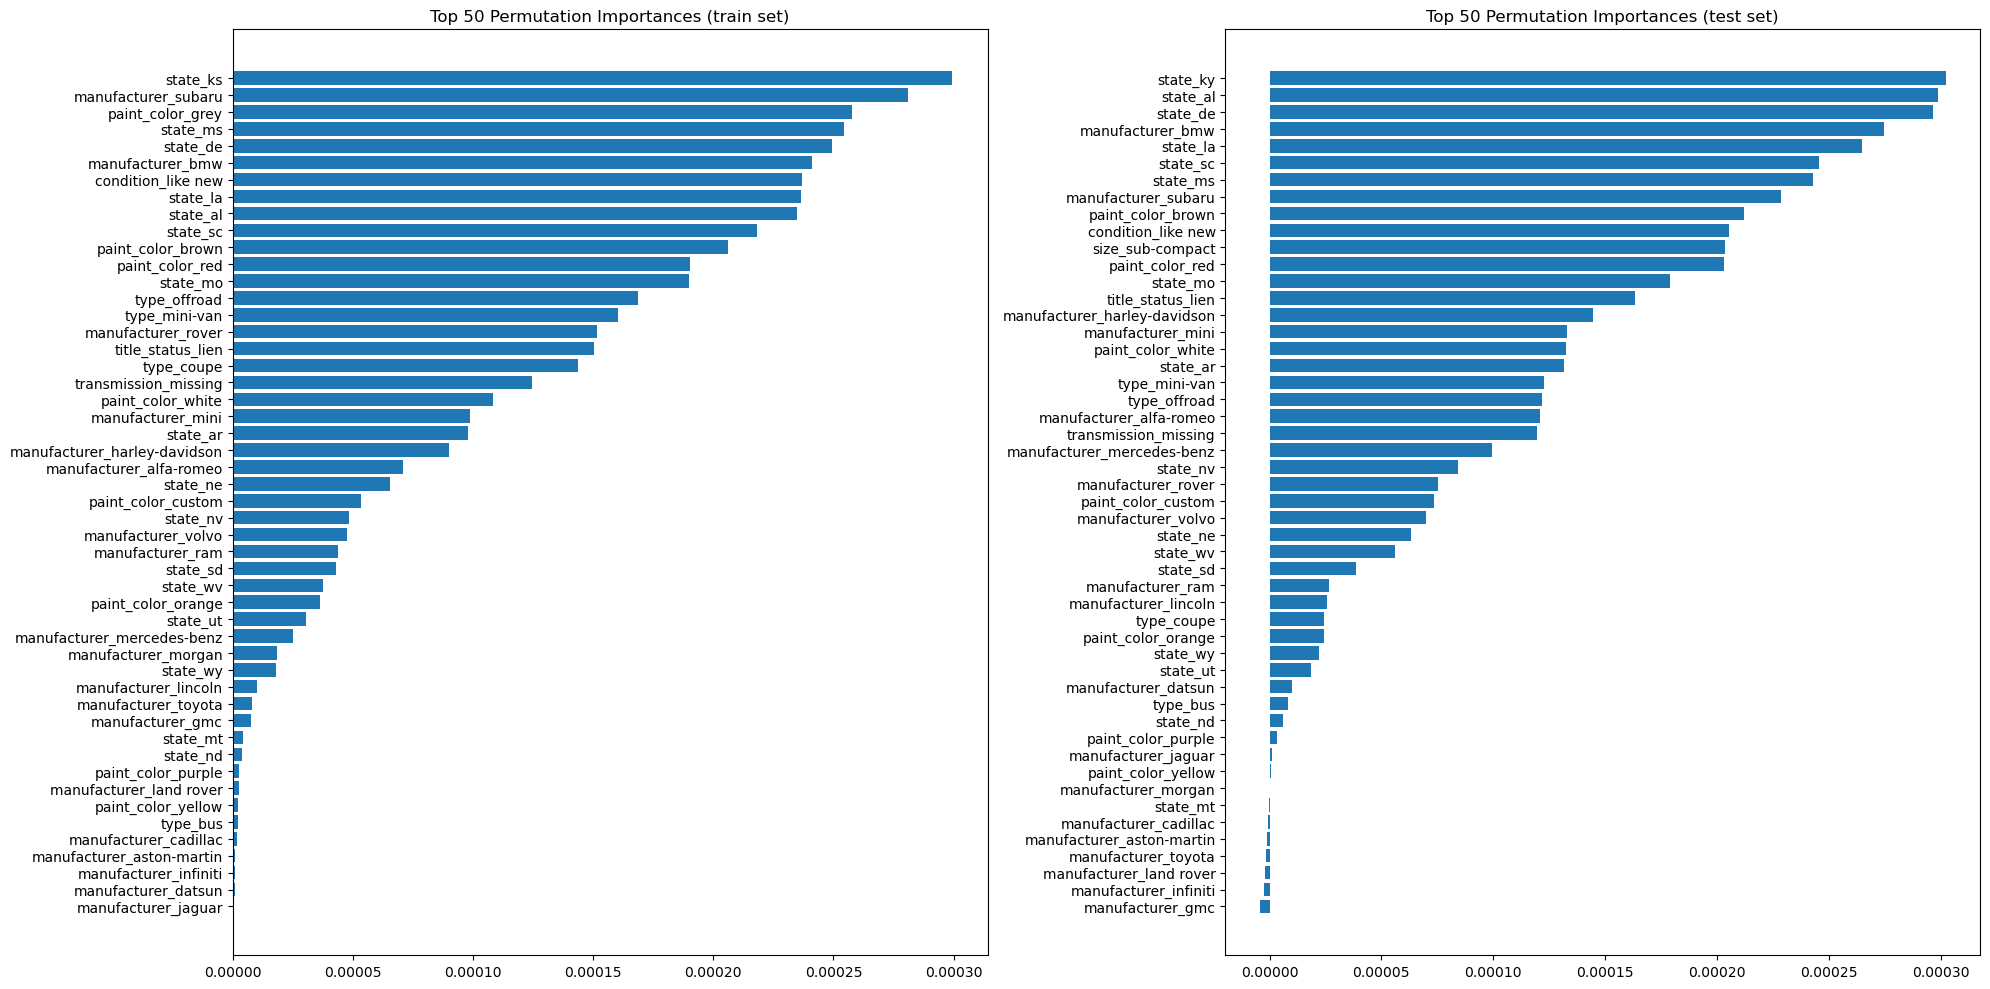

In [182]:
#Create a bar chart of permutation importance for train and test for top 50 features

top_n = 50

sorted_idx_train_top = sorted_idx_train[:top_n]
sorted_idx_test_top = sorted_idx_test[:top_n]

fig, ax = plt.subplots(1, 2, figsize=(20, 10))

ax[0].barh(X_train.columns[sorted_idx_train_top], result_train.importances[sorted_idx_train_top].mean(axis=1).T)
ax[0].set_title("Top 50 Permutation Importances (train set)")

ax[1].barh(X_test.columns[sorted_idx_test_top], result_test.importances[sorted_idx_test_top].mean(axis=1).T)
ax[1].set_title("Top 50 Permutation Importances (test set)")

fig.tight_layout()

# Display the plots
plt.show();

**According to linear regression, the top factors that affect the car price are state, manufacturer, condition and paint color.**

### 2. Ridge Regression

In [183]:
#Build a ridge regression model with a grid search for alpha.
# k for the cross-validation was set to 5 due to run time.

ridge_param_dict = {'ridge__alpha': [0.001, 0.1, 1.0, 10.0, 100.0, 1000.0]}

ridge_pipe = Pipeline([('scaler', StandardScaler()), 
                      ('ridge', Ridge())])

ridge_grid = GridSearchCV(ridge_pipe, param_grid=ridge_param_dict,scoring = 'neg_mean_squared_error', cv = 5)
ridge_grid.fit(X,y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('ridge', Ridge())]),
             param_grid={'ridge__alpha': [0.001, 0.1, 1.0, 10.0, 100.0,
                                          1000.0]},
             scoring='neg_mean_squared_error')

In [184]:
best_score = ridge_grid.best_score_*-1
best_estimator = ridge_grid.best_estimator_
best_selector = best_estimator.named_steps['ridge']
best_selectorAlpha = best_estimator.named_steps['ridge'].alpha
best_selectorFitIntercept = best_estimator.named_steps['ridge'].fit_intercept

coefs = best_estimator.named_steps['ridge'].coef_
intercept = best_estimator.named_steps['ridge'].intercept_

print(f"Best Alpha is {best_selectorAlpha:.3f}.")

Best Alpha is 1000.000.


In [185]:
#Build a Ridge regression model with the best alpha from the GridSearchCV using X_train
ridge_pipe = Pipeline([
    ('scaler2', StandardScaler()), 
    ('ridge2', Ridge(alpha = best_selectorAlpha))
])
ridge_pipe.fit(X_train, y_train)

coefs2 = ridge_pipe.named_steps['ridge2'].coef_
intercept2 = ridge_pipe.named_steps['ridge2'].intercept_

Pipeline(steps=[('scaler2', StandardScaler()), ('ridge2', Ridge(alpha=1000.0))])

In [186]:
#Calculate MSE
ridgereg_mse_train = mean_squared_error(ridge_pipe.predict(X_train),y_train)
ridgereg_mse_test = mean_squared_error(ridge_pipe.predict(X_test),y_test)

print(f"Train MSE is {ridgereg_mse_train:.3f}.")
print(f"Test MSE is {ridgereg_mse_test:.3f}.")

Train MSE is 1.076.
Test MSE is 1.092.


In [187]:
#Prepare a table of variable coefficients

coefList2 = zip(X_train.columns.tolist(),coefs2.tolist())
coefDf2 = pd.DataFrame(coefList2, columns=['Variable','Coefficient']).sort_values(by = "Variable", ascending =True)

coefDf2.head(50)

,Variable,Coefficient
42,condition_fair,-0.115424
43,condition_good,-0.020742
44,condition_like new,0.014213
45,condition_missing,-0.021049
46,condition_salvage,-0.041967
47,cylinders_12 cylinders,0.026530
48,cylinders_3 cylinders,0.012152
49,cylinders_4 cylinders,0.152862
50,cylinders_5 cylinders,0.019431
51,cylinders_6 cylinders,0.228917


In [188]:
#Run permutation importance
result_train2= permutation_importance(ridge_pipe, X_train, y_train, n_repeats=10,
                                random_state=42)
sorted_idx_train2 = result_train2.importances_mean.argsort()

result_test2= permutation_importance(ridge_pipe, X_test, y_test, n_repeats=10,
                                random_state=42)
sorted_idx_test2 = result_test2.importances_mean.argsort();

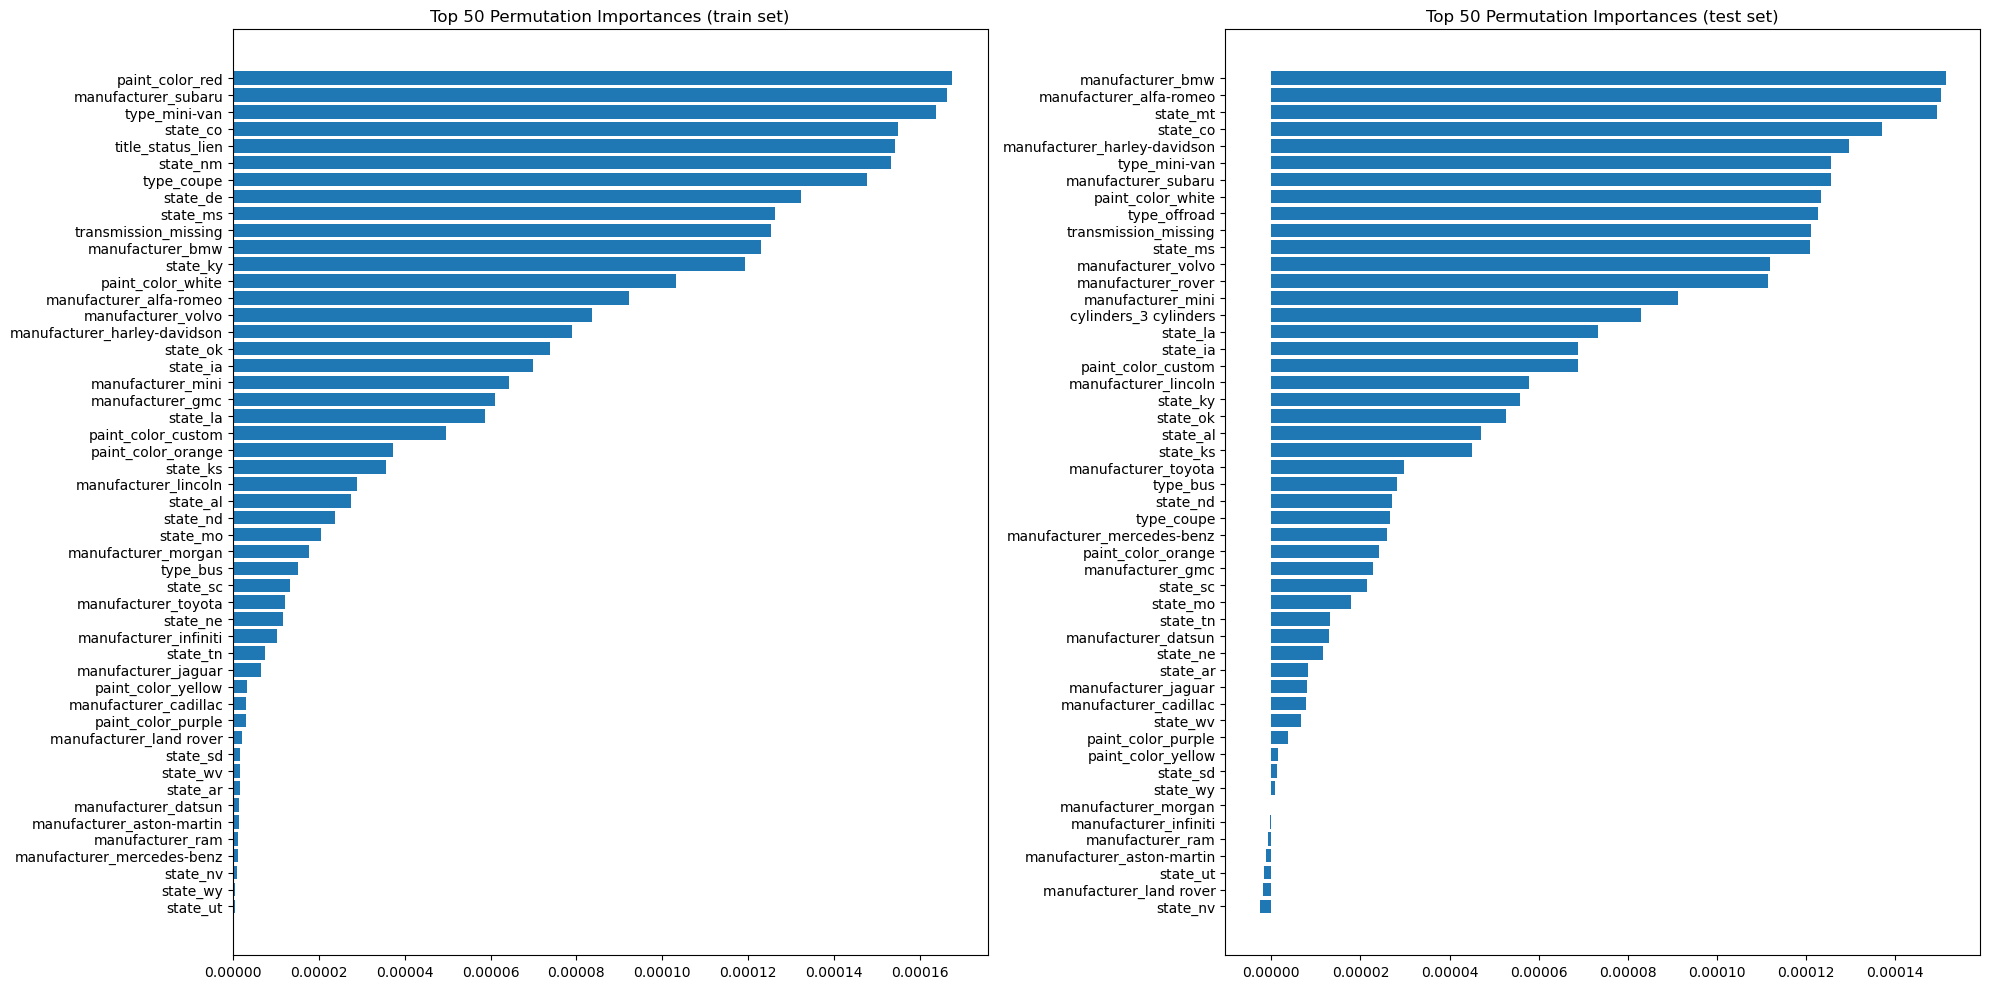

In [189]:
#Create a bar chart of permutation importance for train and test for top 50 features

top_n = 50

sorted_idx_train_top2 = sorted_idx_train2[:top_n]
sorted_idx_test_top2 = sorted_idx_test2[:top_n]

fig, ax = plt.subplots(1, 2, figsize=(20, 10))

ax[0].barh(X_train.columns[sorted_idx_train_top2], result_train2.importances[sorted_idx_train_top2].mean(axis=1).T)
ax[0].set_title("Top 50 Permutation Importances (train set)")

ax[1].barh(X_test.columns[sorted_idx_test_top2], result_test2.importances[sorted_idx_test_top2].mean(axis=1).T)
ax[1].set_title("Top 50 Permutation Importances (test set)")

fig.tight_layout()

# Display the plots
plt.show();

### 3. Lasso Regression

In [190]:
lasso_param_dict = {'lasso__alpha':[0.001, 0.1, 1.0, 10.0, 100.0, 1000.0]}

lasso_pipe = Pipeline([('scaler', StandardScaler()), 
                       ('lasso', Lasso())])
lasso_grid = GridSearchCV(lasso_pipe, param_grid=lasso_param_dict,scoring = 'neg_mean_squared_error', cv = 5)
lasso_grid.fit(X,y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('lasso', Lasso())]),
             param_grid={'lasso__alpha': [0.001, 0.1, 1.0, 10.0, 100.0,
                                          1000.0]},
             scoring='neg_mean_squared_error')

In [191]:
best_score = lasso_grid.best_score_*-1
best_estimator = lasso_grid.best_estimator_
best_selector = best_estimator.named_steps['lasso']
best_selectorAlpha = best_estimator.named_steps['lasso'].alpha
best_selectorFitIntercept = best_estimator.named_steps['lasso'].fit_intercept

coefs = best_estimator.named_steps['lasso'].coef_
intercept = best_estimator.named_steps['lasso'].intercept_

print(f"Best Alpha is {best_selectorAlpha:.3f}.")

Best Alpha is 0.001.


In [192]:
# Print coefficients
print(coefs)

[ 0.01089881  0.00047029  0.02968666 -0.0027386  -0.01430784  0.00538222
 -0.01451462 -0.03495462  0.00286112 -0.05584576  0.0198802  -0.0213179
  0.          0.01153671 -0.006994   -0.01626832 -0.03101821  0.00450816
  0.00339778 -0.01495492 -0.0313493  -0.          0.02668221  0.0081412
 -0.02695487  0.         -0.03327178 -0.0037593  -0.02897143 -0.03246121
 -0.00197682 -0.05065523 -0.01806094  0.03132318  0.0058653   0.01228667
 -0.03057098 -0.00373846  0.02206249  0.01261423 -0.03127169  0.0111976
 -0.11416676 -0.01589245  0.01385685 -0.0165517  -0.04016902  0.02638706
  0.00841296  0.14441824  0.01794643  0.22180226  0.27957657  0.32371264
  0.02762625 -0.04688819 -0.26725247 -0.07668392 -0.02738981 -0.15965795
  0.01074367 -0.05979037 -0.03156034 -0.01521229 -0.03302757  0.03561192
  0.00869919  0.04942717 -0.0770668  -0.065727    0.02323339  0.02534061
  0.04613704  0.16370466  0.01181847 -0.00332421  0.01889088  0.00683905
 -0.0349044  -0.01047918 -0.08495183  0.00916791  0.04

In [193]:
# Identify non-zero coefficients and extract corresponding feature names
non_zero_coeff_indices = np.where(coefs != 0)[0]
non_zero_features = X.columns[non_zero_coeff_indices]

# Display the non-zero features and their coefficients
non_zero_coefficients = coefs[non_zero_coeff_indices]

# Print the features with non-zero coefficients
for feature, coef in zip(non_zero_features, non_zero_coefficients):
    print(f"Feature: {feature}, Coefficient: {coef}")

Feature: manufacturer_alfa-romeo, Coefficient: 0.010898807999803762
Feature: manufacturer_aston-martin, Coefficient: 0.0004702898469152339
Feature: manufacturer_audi, Coefficient: 0.02968666395512168
Feature: manufacturer_bmw, Coefficient: -0.0027385951809128723
Feature: manufacturer_buick, Coefficient: -0.014307837036976512
Feature: manufacturer_cadillac, Coefficient: 0.005382223586370817
Feature: manufacturer_chevrolet, Coefficient: -0.014514618533805994
Feature: manufacturer_chrysler, Coefficient: -0.03495461846054603
Feature: manufacturer_datsun, Coefficient: 0.002861124595975176
Feature: manufacturer_dodge, Coefficient: -0.05584575509925829
Feature: manufacturer_ferrari, Coefficient: 0.019880203337388824
Feature: manufacturer_fiat, Coefficient: -0.021317900358207225
Feature: manufacturer_gmc, Coefficient: 0.01153670624784272
Feature: manufacturer_harley-davidson, Coefficient: -0.006993997186890528
Feature: manufacturer_honda, Coefficient: -0.01626832399786185
Feature: manufacturer

In [194]:
#Build a Lasso regression model with the best alpha from the GridSearchCV using X_train
lasso_pipe = Pipeline([
    ('scaler2', StandardScaler()), 
    ('lasso2', Lasso(alpha = best_selectorAlpha))
])
lasso_pipe.fit(X_train, y_train)

coefs2 = lasso_pipe.named_steps['lasso2'].coef_
intercept2 = lasso_pipe.named_steps['lasso2'].intercept_

Pipeline(steps=[('scaler2', StandardScaler()), ('lasso2', Lasso(alpha=0.001))])

In [195]:
#Calculate MSE
lassoreg_mse_train = mean_squared_error(lasso_pipe.predict(X_train),y_train)
lassoreg_mse_test = mean_squared_error(lasso_pipe.predict(X_test),y_test)

print(f"Train MSE is {lassoreg_mse_train:.3f}.")
print(f"Test MSE is {lassoreg_mse_test:.3f}.")

Train MSE is 1.076.
Test MSE is 1.093.


### 4. Feature Selection using Lasso

In [196]:
# Define the Lasso model pipeline with scaling
lasso_model = Pipeline([
    ('scaler', StandardScaler()),  
    ('lasso', Lasso(alpha=0.001))  # the best alpha from the Lasso grid search above
])

In [197]:
# Initialize Sequential Feature Selector to select 20 features
sfs = SequentialFeatureSelector(estimator=lasso_model, 
                                n_features_to_select=20, 
                                direction='forward',
                                scoring='neg_mean_squared_error',
                                cv=5)  # 5-fold cross-validation

In [198]:
# Fit SFS to the training data
sfs.fit(X_train, y_train)


SequentialFeatureSelector(estimator=Pipeline(steps=[('scaler',
                                                     StandardScaler()),
                                                    ('lasso',
                                                     Lasso(alpha=0.001))]),
                          n_features_to_select=20,
                          scoring='neg_mean_squared_error')

In [199]:
# Get the indices of the selected features
selected_features_indices = sfs.get_support(indices=True)

# Get the names of the selected features
selected_features = X.columns[selected_features_indices]

# Print the selected features
print("Selected Features: ")
for feature in selected_features:
    print(feature)

Selected Features: 
condition_fair
condition_salvage
cylinders_4 cylinders
cylinders_8 cylinders
fuel_gas
fuel_hybrid
fuel_other
title_status_missing
drive_fwd
drive_missing
size_missing
type_other
type_pickup
type_truck
paint_color_missing
state_fl
state_me
state_or
year
odometer


In [200]:
# Fit the final model on the selected features using the best alpha
Xtrain_selected = X_train[selected_features]  # Subset of X train  with selected features
Xtest_selected = X_test[selected_features]  # Subset of X test with selected features
lasso_model.fit(Xtrain_selected, y_train)  # Fit the model on the selected features

# Predict on the training and test set
y_pred_train = lasso_model.predict(Xtrain_selected)
y_pred_test = lasso_model.predict(Xtest_selected)

# Calculate the Mean Squared Error (MSE)
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
print(f"Train MSE is {mse_train:.3f}.")
print(f"Test MSE is {mse_test:.3f}.")

Pipeline(steps=[('scaler', StandardScaler()), ('lasso', Lasso(alpha=0.001))])

Train MSE is 1.128.
Test MSE is 1.145.


### 5. Linear Regression with Polynomial Features Based on 20 selected variables

In [201]:
# Define the pipeline 
pipeline = Pipeline([
    ('scaler', StandardScaler()),             # Standardize the features
    ('poly', PolynomialFeatures()),           # Polynomial features
    ('linear', LinearRegression())            # Linear regression model
])

In [202]:
# Define the parameter grid (degrees of polynomial features to test)
param_grid = {
    'poly__degree': [1, 2, 3]           # Test polynomial degrees from 1 to 3 (limited due to run time)
}

In [203]:
# Set up the GridSearchCV to search for the best degree of polynomial features
grid_search = GridSearchCV(estimator=pipeline, 
                           param_grid=param_grid, 
                           scoring='neg_mean_squared_error',  
                           cv=5)  # 5-fold cross-validation

# Fit the model and search for the best degree
grid_search.fit(Xtrain_selected, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('poly', PolynomialFeatures()),
                                       ('linear', LinearRegression())]),
             param_grid={'poly__degree': [1, 2, 3]},
             scoring='neg_mean_squared_error')

In [204]:
# Get the best degree
best_degree = grid_search.best_params_['poly__degree']
print(f"Best degree for polynomial features: {best_degree}")

Best degree for polynomial features: 2


In [205]:
# Get the best model (with the best degree of polynomial features)
best_model = grid_search.best_estimator_

# Make predictions 
y_train_pred = best_model.predict(Xtrain_selected)
y_test_pred = best_model.predict(Xtest_selected)



In [206]:
# Calculate and print the Mean Squared Errors (MSE) 
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

print(f"Training Mean Squared Error (MSE): {train_mse:.3f}.")
print(f"Test Mean Squared Error (MSE): {test_mse:.3f}.")

Training Mean Squared Error (MSE): 1.010.
Test Mean Squared Error (MSE): 1.026.


### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight on drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

#### As a part of this analysis we developed the following models to assess what factors drive the price of the used car:

1. Linear regression
1. Ridge Regression
1. Lasso Regression
1. Feature Selection using Lasso
1. Linear Regression with Polynomial Features (2-Degree) Based on 20 selected variables


The table below summarizes the model performance results for each modeling technique:
|Step |Modeling Technique |Train MSE |Test MSE |
|:---: |:---:|:---:|:---:|
|1 |Linear Regression |1.075 |1.091|
|2 |Ridge Regression | 1.076 | 1.092|
|3 |Lasso Regression | 1.076 | 1.093|
|4 |Feature Selection using Lasso| 1.128 |1.145|
|5 |Linear Regression with 2-Degree Polynomial Features based on 20 selected variables|1.01 |1.026
                                    

- The multiple linear regression model was built as a benchmark model,but ended up being top second model based on performance
- Ridge and Lasso regresisons had comparable performance
- A more condenced model was developed with 20 features using sequential forward selection but it came at a cost of higher MSE.
- The best model was the 2-degree polynomial features linear regression, based on 20 features selected with sequential forward selection in the previous step. Ideally, it would make sense to try to build this model using all the features, but the process is very computationally intense and the job would take a very long time and may never finish.

The following variables are the top predictors in the model:

- Condition of the car  (Fair, Salvage)
- Number of cylinders (4, 6)
- Fuel type (gas, hybrid and other)
- Drive type (fwd and missing)
- Size (missing)
- Type (pickup, truck and other)
- State (FL, ME, OR)
- Year
- Odometer

This analysis has the following limitations:

- There are a large number of records with missing and other values. Instead of imputing these values, we decided to use hot encoding after assigning missing and other to different categories, which increased the dimensionality of the dataset. 
- The data was very granular for variables such as region, model and state. All this information may be valuable in predicting a price of a car, but having all of thse variables one-hot-encoded produces a very large dataset. If there was a way to consolidate these features to have fewer values, the analysis could be expanded. 
- Given that there were outliers in the data (very old cards dated as of 1900) and very expensive luxury cars, building a set of segmented models instead of one model could also improve the prediction quality. For example, we could build a separate model for luxury cars and another model for economy cars. We can also build a different model for very old antique cars and another model for newer cars.

### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine tuning their inventory.

### Primary Findings on Factors that Drive the Price of a Car

#### Executive Summary
Several factors have an impact on the resale value of cars:
- Condition of the car 
- Number of cylinders 
- Fuel type
- Drive type 
- State
- Age
- Mileage

The analysis showed newer cars tend to have a much higher resale value, and cars with more than 50k miles have lower resale value. The plots below shows the distribution of the car price by year and mileage.

![Screenshot](./images/CarPriceNumChars.jpg)

In addition to age and mileage, other  important factors for the resale value are condition, number of cylinders, fuel and drive type.

![Screenshot](./images/CarPriceCatChars.jpg)

Using these features and other factors like color of the car, state and manufacturer we developed several models to predict the resale price of a car. We used logarithm of the price of the car as a target variable. 
The best model has train MSE of 1.01 and test MSE of 1.026, which translates to approximately 9% error rate in prediction of the price of a car.

We identified opportunities to further enhance the prediction by improving quality of the data and potentially developing separate models for luxury and antique cars as well as different types of cars.